## Further Development of Datasets 

### Summary of Findings
The goal of this notebook is to begin the geographical modeling and visual representations of the datasets collected.  The introduction of the demographic data from SimplyAnalytics has added some new insights and direction to the initial plan of approach.  As such, the notebook is less complete than initially hoped.

Visually the data shows the presence of signs and traffic accidents throughout the city of Toronto with much overlap.  The initial plan do run analysis by Ward (2012 with 44 wards) would have likely proven insufficient.  Further granularity would help produce more accurate results in the overall analysis.  Fortunately, the geodemographic dataset breaks the city out into its census tracts of 572 total divisions.

The next steps will likely include some geoclustering analysis on the various demographic factors, street sign locations, and traffic accidents.

In [1]:
# Import required libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import shapely.speedups
from fiona.crs import from_epsg
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


### Third Party Sign Dataset 

In [2]:
# File paths
fp_signs = '../data/CleanSigns/signs.csv'


In [3]:
# Create dataframe
df_signs = pd.read_csv(fp_signs)

In [4]:
df_signs.head()

Sign Account Street Number  Street Name Size (LxW)  \
0       44-001     4566-4568  KINGSTON RD    10 x 20   
1       44-001     4566-4568  KINGSTON RD    10 x 20   
2       44-002          4528  KINGSTON RD    10 x 20   
3       44-002          4528  KINGSTON RD    10 x 20   
4       44-002          4528  KINGSTON RD    10 x 20   

                Location Description (if no address)  X Coordinate  \
0  On Kingston Rd. between Military Trail & Morni...     330183.18   
1  On Kingston Rd. between Military Trail & Morni...     330184.17   
2  On Kingston Rd. between Military Trail & Morni...     330055.54   
3  On Kingston Rd. between Military Trail & Morni...     330059.83   
4  On Kingston Rd. between Military Trail & Morni...     330061.23   

   Y Coordinate Sign Type Sign Technology Sign Face Direction Illumination  \
0    4848008.89    Ground          STATIC                   W         Down   
1    4848001.36    Ground          STATIC                   E         Down   
2    4847844.62      Roof          STATIC                  NE           Up   
3    4847841.82      Roof          STATIC                  NE           Up   
4    4847842.89      Roof          STATIC                  SW           Up   

  Sign Owner Sign Owner Identifier  \
0   PATTISON                 5364A   
1   PATTISON                 5364B   
2        CBS                  1633   
3        CBS                  1634   
4        CBS                  1631   

                           Context Picture Hyperlink  Ward_ID  
0  http://maps.live.com/default.aspx?v=2&FORM=LML...       44  
1  http://maps.live.com/default.aspx?v=2&FORM=LML...       44  
2  http://maps.live.com/default.aspx?v=2&FORM=LML...       44  
3  http://maps.live.com/default.aspx?v=2&FORM=LML...       44  
4  http://maps.live.com/default.aspx?v=2&FORM=LML...       44

In [5]:
# In order to create a GeoDataFrame object from the text file, 
# create a column to store the shapely geometries
df_signs['geometry'] = None

In [6]:
# Create the Point objects in the geometry column
for index, row in df_signs.iterrows():
    df_signs.loc[index,'geometry'] = Point(row['X Coordinate'], row['Y Coordinate'])
    

In [7]:
df_signs.head()

Sign Account Street Number  Street Name Size (LxW)  \
0       44-001     4566-4568  KINGSTON RD    10 x 20   
1       44-001     4566-4568  KINGSTON RD    10 x 20   
2       44-002          4528  KINGSTON RD    10 x 20   
3       44-002          4528  KINGSTON RD    10 x 20   
4       44-002          4528  KINGSTON RD    10 x 20   

                Location Description (if no address)  X Coordinate  \
0  On Kingston Rd. between Military Trail & Morni...     330183.18   
1  On Kingston Rd. between Military Trail & Morni...     330184.17   
2  On Kingston Rd. between Military Trail & Morni...     330055.54   
3  On Kingston Rd. between Military Trail & Morni...     330059.83   
4  On Kingston Rd. between Military Trail & Morni...     330061.23   

   Y Coordinate Sign Type Sign Technology Sign Face Direction Illumination  \
0    4848008.89    Ground          STATIC                   W         Down   
1    4848001.36    Ground          STATIC                   E         Down   
2    4847844.62      Roof          STATIC                  NE           Up   
3    4847841.82      Roof          STATIC                  NE           Up   
4    4847842.89      Roof          STATIC                  SW           Up   

  Sign Owner Sign Owner Identifier  \
0   PATTISON                 5364A   
1   PATTISON                 5364B   
2        CBS                  1633   
3        CBS                  1634   
4        CBS                  1631   

                           Context Picture Hyperlink  Ward_ID  \
0  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
1  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
2  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
3  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
4  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   

                       geometry  
0  POINT (330183.18 4848008.89)  
1  POINT (330184.17 4848001.36)  
2  POINT (330055.54 4847844.62)  
3  POINT (330059.83 4847841.82)  
4  POINT (330061.23 4847842.89)

In [8]:
# Convert the dataframe into a GeoDataFrame epsg=32190 (for MTM Zone 10)
gdf_signs = gpd.GeoDataFrame(df_signs, geometry='geometry', crs=from_epsg(32190))
gdf_signs.crs

{'init': 'epsg:32190', 'no_defs': True}

#### NOTE:
MTM Zone 10 is the CRS (co-ordinate reference system) commonly used in Canada for the Toronto region.  It provides for an accuracy of 1 metre.  This CRS will be used for the project going forward.

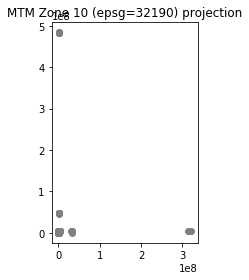

In [9]:
# Plot the WGS84
gdf_signs.plot(facecolor='gray');

# Add title
plt.title("MTM Zone 10 (epsg=32190) projection");

# Remove empty white space around the plot
plt.tight_layout()


#### NOTE:
Clearly some outliers are affecting this plot.  These will be dealt with when the other datasets are introduced.

### Wards Dataset
This is the initial dataset used to provide the visual map of Toronto.

In [10]:
# Import the wards file

# File path
fpw = '../data/Wards_wgs84/icitw_wgs84.shp'


In [11]:
# Create the dataframe
gdf_wards = gpd.read_file(fpw)
gdf_wards.crs

{'init': 'epsg:4326'}

#### NOTE:
As discussed above, the project will make use of the MTM Zone 10 CRS (epsg:32190).  The Wards dataset will need to be altered to be compatible with the signs dataset.

In [12]:
gdf_wards.head()

GEO_ID  CREATE_ID                          NAME SCODE_NAME LCODE_NAME  \
0  14630026      63519  Scarborough-Rouge River (41)         41       EA41   
1  14630028      63519         Scarborough East (44)         44       EA44   
2  14630024      63519  Scarborough-Rouge River (42)         42       EA42   
3  14630027      63519    Scarborough-Agincourt (39)         39       EA39   
4  14630035      63519               Willowdale (24)         24       NO24   

  TYPE_DESC TYPE_CODE  OBJECTID  SHAPE_AREA  SHAPE_LEN  \
0      Ward      CITW         1         0.0        0.0   
1      Ward      CITW         2         0.0        0.0   
2      Ward      CITW         3         0.0        0.0   
3      Ward      CITW         4         0.0        0.0   
4      Ward      CITW         5         0.0        0.0   

                                            geometry  
0  POLYGON ((-79.26485565927024 43.77955621985134...  
1  POLYGON ((-79.17076824694337 43.75563765091391...  
2  POLYGON ((-79.22568464642563 43.78940329829909...  
3  POLYGON ((-79.33141527345541 43.79311828976419...  
4  POLYGON ((-79.38719566413288 43.76348086985467...

In [13]:
gdf_wardproj = gdf_wards.to_crs(gdf_signs.crs)
gdf_wardproj.crs

{'init': 'epsg:32190', 'no_defs': True}

In [14]:
print(gdf_wardproj.shape)
print(gdf_wardproj.head())

(44, 11)
     GEO_ID  CREATE_ID                          NAME SCODE_NAME LCODE_NAME  \
0  14630026      63519  Scarborough-Rouge River (41)         41       EA41   
1  14630028      63519         Scarborough East (44)         44       EA44   
2  14630024      63519  Scarborough-Rouge River (42)         42       EA42   
3  14630027      63519    Scarborough-Agincourt (39)         39       EA39   
4  14630035      63519               Willowdale (24)         24       NO24   

  TYPE_DESC TYPE_CODE  OBJECTID  SHAPE_AREA  SHAPE_LEN  \
0      Ward      CITW         1         0.0        0.0   
1      Ward      CITW         2         0.0        0.0   
2      Ward      CITW         3         0.0        0.0   
3      Ward      CITW         4         0.0        0.0   
4      Ward      CITW         5         0.0        0.0   

                                            geometry  
0  POLYGON ((323727.8313023802 4848870.781534879,...  
1  POLYGON ((331311.9180867801 4846239.315869188,...  
2  POLYG

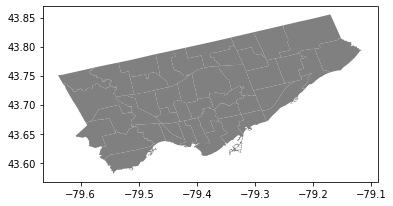

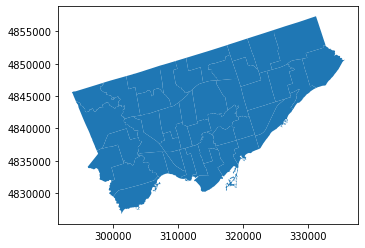

In [15]:
gdf_wards.plot(facecolor='gray')
gdf_wardproj.plot()

#### NOTE:
Notice the difference between the WGS84 (epsg:4326) projection in grey versus the MTM Zone 10 (epsg:32190) projection.

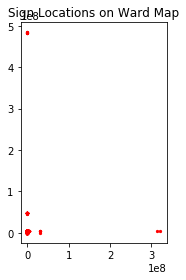

In [16]:
fig, ax = plt.subplots()

gdf_wardproj.plot(ax=ax, facecolor='gray');

gdf_signs.plot(ax=ax, color='red', markersize=5);

ax.set_title('Sign Locations on Ward Map')

plt.tight_layout();

#### NOTE:
The outliers are still an issue at this point.

In [17]:
shapely.speedups.enable()

In [18]:
# Let's focus only on the signs that appear in the wards
gdf_signs['Ward_Found'] = None

for index, row in gdf_wardproj.iterrows():
    point_in_ward = gdf_signs.within(gdf_wardproj.loc[index, 'geometry'])
    gdf_signs.loc[point_in_ward, 'Ward_Found'] = gdf_wardproj.loc[index, 'SCODE_NAME']

gdf_found_signs = gdf_signs[~gdf_signs['Ward_Found'].isnull()]

In [19]:
gdf_found_signs.shape

(4008, 17)

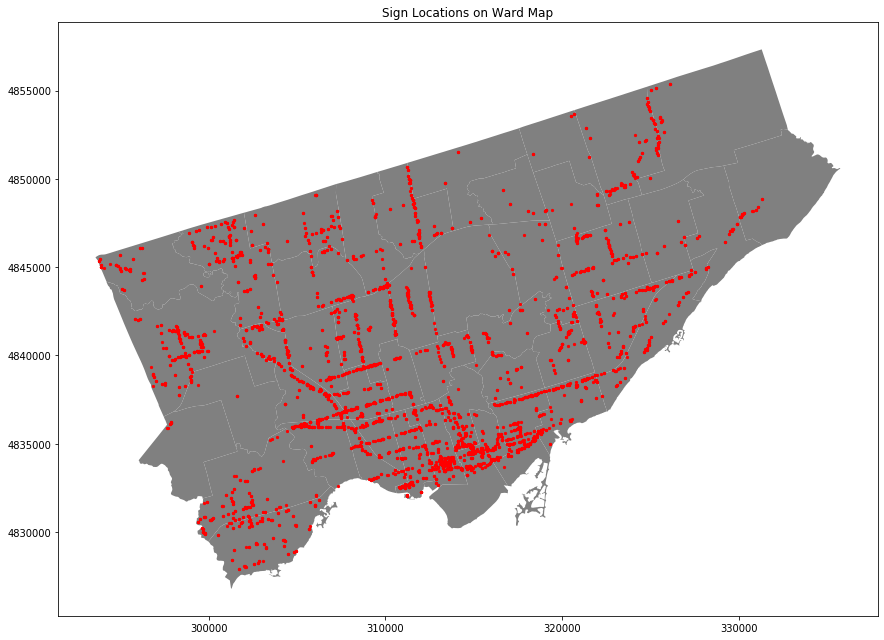

In [20]:
fig, ax = plt.subplots(figsize=(16,9))

gdf_wardproj.plot(ax=ax, facecolor='gray');

gdf_found_signs.plot(ax=ax, color='red', markersize=5);

ax.set_title('Sign Locations on Ward Map')

plt.tight_layout();

#### NOTE:
The above shows the sign locations excluding the outliers.  The signs in red can be seen throughout the city, though mostly in the south-central region.

### KSI Data

In [21]:
# KSI data

# File path
fp_ksi = '../data/KSIData/KSI.csv'

In [22]:
# Create dataframe
df_ksi = pd.read_csv(fp_ksi)
df_ksi.head()

X          Y    Index_      ACCNUM  YEAR                      DATE  \
0 -79.454730  43.675280  80771254  7001005616  2017  2017-06-03T04:00:00.000Z   
1 -79.520641  43.770049  80783528  7001744141  2017  2017-09-25T04:00:00.000Z   
2 -79.520641  43.770049  80783529  7001744141  2017  2017-09-25T04:00:00.000Z   
3 -79.286601  43.751868  80790062  7003112978  2017  2017-12-01T05:00:00.000Z   
4 -79.286601  43.751868  80790894  7003112978  2017  2017-12-01T05:00:00.000Z   

   TIME  Hour         STREET1        STREET2  ... AG_DRIV REDLIGHT ALCOHOL  \
0  2330    23  ST CLAIR AVE W   CALEDONIA RD  ...     Yes                    
1  2330    23    4673 JANE ST                 ...     Yes                    
2  2330    23    4673 JANE ST                 ...     Yes                    
3  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                            
4  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                            

   DISABILITY  Division Ward_Name Ward_ID Hood_ID Hood_Name ObjectId  
0                    13       NaN     NaN      92       NaN    12001  
1                    31       NaN     NaN      24       NaN    12002  
2                    31       NaN     NaN      24       NaN    12003  
3                    41       NaN     NaN     126       NaN    12004  
4                    41       NaN     NaN     126       NaN    12005  

[5 rows x 57 columns]

In [23]:
# In order to create a GeoDataFrame object from the text file, 
# create a column to store the shapely geometries
df_ksi['geometry'] = None

In [24]:
# Create the Point objects in the geometry column
for index, row in df_ksi.iterrows():
    df_ksi.loc[index,'geometry'] = Point(row['X'], row['Y'])
    

In [25]:
df_ksi.head()

X          Y    Index_      ACCNUM  YEAR                      DATE  \
0 -79.454730  43.675280  80771254  7001005616  2017  2017-06-03T04:00:00.000Z   
1 -79.520641  43.770049  80783528  7001744141  2017  2017-09-25T04:00:00.000Z   
2 -79.520641  43.770049  80783529  7001744141  2017  2017-09-25T04:00:00.000Z   
3 -79.286601  43.751868  80790062  7003112978  2017  2017-12-01T05:00:00.000Z   
4 -79.286601  43.751868  80790894  7003112978  2017  2017-12-01T05:00:00.000Z   

   TIME  Hour         STREET1        STREET2  ... REDLIGHT ALCOHOL DISABILITY  \
0  2330    23  ST CLAIR AVE W   CALEDONIA RD  ...                               
1  2330    23    4673 JANE ST                 ...                               
2  2330    23    4673 JANE ST                 ...                               
3  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                               
4  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                               

   Division  Ward_Name Ward_ID Hood_ID Hood_Name ObjectId  \
0        13        NaN     NaN      92       NaN    12001   
1        31        NaN     NaN      24       NaN    12002   
2        31        NaN     NaN      24       NaN    12003   
3        41        NaN     NaN     126       NaN    12004   
4        41        NaN     NaN     126       NaN    12005   

                       geometry  
0    POINT (-79.45473 43.67528)  
1  POINT (-79.520641 43.770049)  
2  POINT (-79.520641 43.770049)  
3  POINT (-79.286601 43.751868)  
4  POINT (-79.286601 43.751868)  

[5 rows x 58 columns]

In [26]:
# Convert the dataframe into a GeoDataFrame epsg=4326 (for WGS84)
gdf_ksi = gpd.GeoDataFrame(df_ksi, geometry='geometry', crs=from_epsg(4326))
gdf_ksi.crs

{'init': 'epsg:4326', 'no_defs': True}

In [27]:
gdf_ksiproj = gdf_ksi.to_crs(gdf_signs.crs)
gdf_ksiproj.crs

{'init': 'epsg:32190', 'no_defs': True}

In [28]:
print(gdf_ksiproj.shape)
print(gdf_ksiproj.head())

(12244, 58)
           X          Y    Index_      ACCNUM  YEAR                      DATE  \
0 -79.454730  43.675280  80771254  7001005616  2017  2017-06-03T04:00:00.000Z   
1 -79.520641  43.770049  80783528  7001744141  2017  2017-09-25T04:00:00.000Z   
2 -79.520641  43.770049  80783529  7001744141  2017  2017-09-25T04:00:00.000Z   
3 -79.286601  43.751868  80790062  7003112978  2017  2017-12-01T05:00:00.000Z   
4 -79.286601  43.751868  80790894  7003112978  2017  2017-12-01T05:00:00.000Z   

   TIME  Hour         STREET1        STREET2  ... REDLIGHT ALCOHOL DISABILITY  \
0  2330    23  ST CLAIR AVE W   CALEDONIA RD  ...                               
1  2330    23    4673 JANE ST                 ...                               
2  2330    23    4673 JANE ST                 ...                               
3  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                               
4  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                               

   Division  W

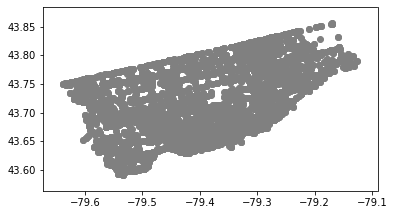

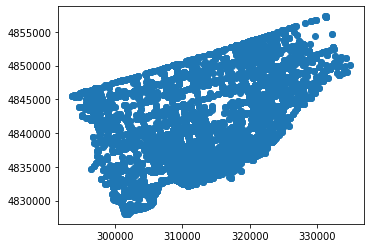

In [29]:
gdf_ksi.plot(facecolor='gray')
gdf_ksiproj.plot()

#### NOTE:
The above is just a simple visual comparison of the two CSR settings.  Again, the MTM Zone 10 CSR shown in blue will be used for this project.

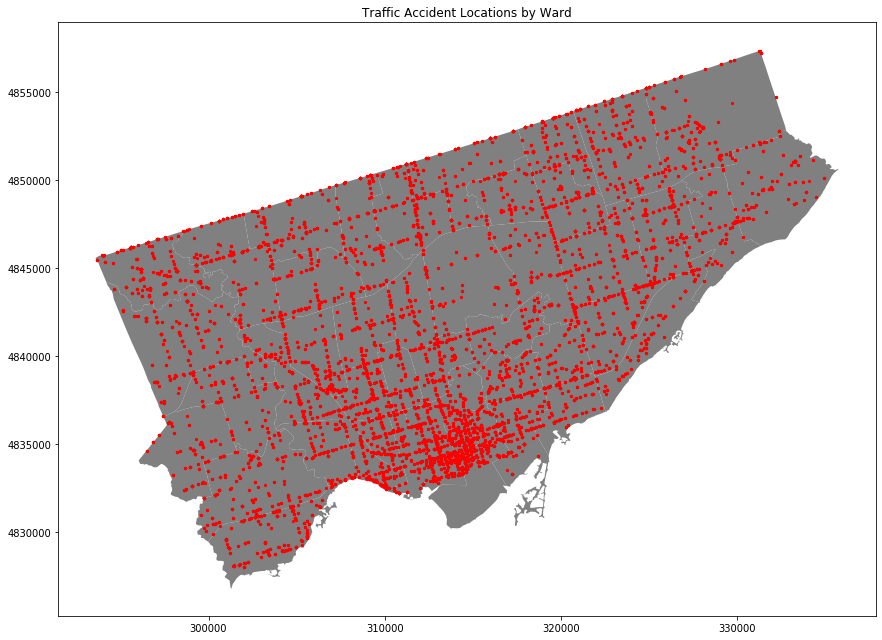

In [30]:
fig, ax = plt.subplots(figsize=(16,9))

gdf_wardproj.plot(ax=ax, facecolor='gray');

gdf_ksiproj.plot(ax=ax, color='red', markersize=5);

ax.set_title('Traffic Accident Locations by Ward')

plt.tight_layout();

#### NOTE:
As with the signs, the traffic accidents are spread throughout the city.  The next visual will show how these overlap.

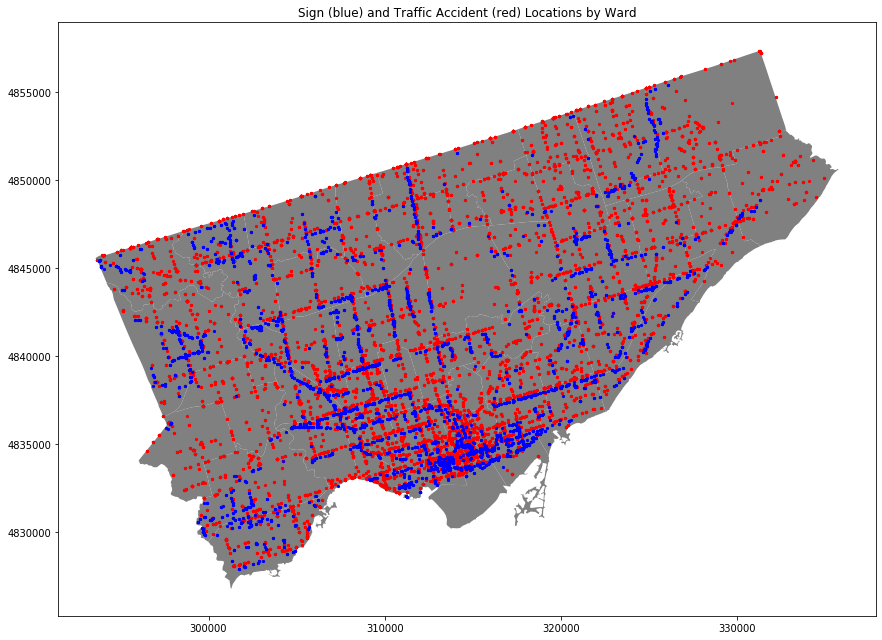

In [31]:
# Combine the KSI and sign data onto the map
fig, ax = plt.subplots(figsize=(16,9))

gdf_wardproj.plot(ax=ax, facecolor='gray');

gdf_ksiproj.plot(ax=ax, color='red', markersize=5);
gdf_found_signs.plot(ax=ax, color='blue', markersize=5);

ax.set_title('Sign (blue) and Traffic Accident (red) Locations by Ward')

plt.tight_layout();

#### NOTE:
Certainly a lot of overlap, but there are some gaps where accidents exist with no third party sign presence.

### Demographic Data from SimplyAnalytics

In [32]:
# Import the demographic shapefile

# File path
#fp_dem = '../data/CensusData/SimplyAnalytics_Shapefiles_2019-08-04_22_04_58_29ee95b93fb0808302bdd375a72e2de5.shp'
fp_dem = '../data/CensusData/SimplyAnalytics_Shapefiles_2019-08-10_17_37_09_7402e6a23d0aac72c66a65d238978da2.shp'

In [33]:
# Create the Geopandas dataframe
gdf_dem = gpd.read_file(fp_dem)
gdf_dem.shape

(572, 13)

#### NOTE:
With 572 census tracts, greater granularity can be introduced into the analysis.  This dataset will be the base for dividing the city going forward.

In [34]:
gdf_dem.head()

spatial_id                    name  VALUE0  VALUE1  VALUE2  VALUE3  \
0  5350001.00  CT0001.00, Toronto, ON   249.0   600.0    88.0    15.0   
1  5350002.00  CT0002.00, Toronto, ON   267.0   613.0    74.0     7.0   
2  5350003.00  CT0003.00, Toronto, ON   537.0  1557.0   219.0    28.0   
3  5350004.00  CT0004.00, Toronto, ON  3712.0  7177.0   342.0   121.0   
4  5350005.00  CT0005.00, Toronto, ON  3722.0  6969.0   445.0   127.0   

      VALUE4    VALUE5  VALUE6   VALUE7        VALUE8        VALUE9  \
0  120561.50  79727.91    22.0  72.5000  2.359562e+07  3.548888e+07   
1   75392.63  74505.79     0.0  89.1566  1.630873e+07  2.219318e+07   
2  120833.84  88073.28    17.0  53.8462  4.888142e+07  7.189374e+07   
3   54432.35  27670.45   392.0  50.0513  1.598141e+08  1.887939e+08   
4   65003.69  33807.26   301.0  55.8916  1.946197e+08  2.474892e+08   

                                            geometry  
0  POLYGON ((-79.30312052680827 43.6557792424362,...  
1  POLYGON ((-79.34874705621597 43.63005940385361...  
2  POLYGON ((-79.43442817686808 43.63362770070954...  
3  POLYGON ((-79.43602519603924 43.63716951121133...  
4  POLYGON ((-79.42457648823653 43.64104908625342...

In [35]:
# Rename the VALUE columns
#colnames = {'VALUE0': 'Total_Household_Count',\
#           'VALUE1': 'Total_Population_Count',\
#           'VALUE2': 'Total_No_PS_Education_Count',\
#           'VALUE3': 'Total_PS_Education_Count',\
#           'VALUE4': 'Total_Marital_Status_Count',\
#           'VALUE5': 'Total_Household_Immigrants_Count',\
#           'VALUE6': 'Total_Current_Consumption_Dollars',\
#           'VALUE7': 'Avg_Current_Consumption_Dollars'}
colnames = {'VALUE0': 'Total_Household_Count',\
           'VALUE1': 'Total_Population_Count',\
           'VALUE2': 'Total_Income_Over_100K_Count',\
           'VALUE3': 'Total_Income_Over_250K_Count',\
           'VALUE4': 'Avg_Household_Income_Dollars',\
           'VALUE5': 'Median_Household_Income_Dollars',\
           'VALUE6': 'Total_Population_Languages_No_Eng_French_Count',\
           'VALUE7': 'Total_Houshold_Mother_Tongue_Eng_Pct',\
           'VALUE8': 'Total_Current_Consumption_Dollars',\
           'VALUE9': 'Total_Expenditure_Dollars',\
           }

gdf_dem = gdf_dem.rename(columns=colnames)
gdf_dem.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 13 columns):
spatial_id                                        572 non-null object
name                                              572 non-null object
Total_Household_Count                             572 non-null float64
Total_Population_Count                            572 non-null float64
Total_Income_Over_100K_Count                      572 non-null float64
Total_Income_Over_250K_Count                      572 non-null float64
Avg_Household_Income_Dollars                      572 non-null float64
Median_Household_Income_Dollars                   572 non-null float64
Total_Population_Languages_No_Eng_French_Count    572 non-null float64
Total_Houshold_Mother_Tongue_Eng_Pct              572 non-null float64
Total_Current_Consumption_Dollars                 572 non-null float64
Total_Expenditure_Dollars                         572 non-null float64
geometry                             

In [36]:
gdf_dem.crs

{'init': 'epsg:4326'}

In [37]:
gdf_demproj = gdf_dem.to_crs(gdf_signs.crs)
gdf_demproj.crs

{'init': 'epsg:32190', 'no_defs': True}

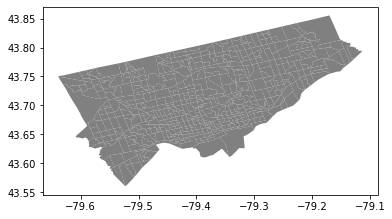

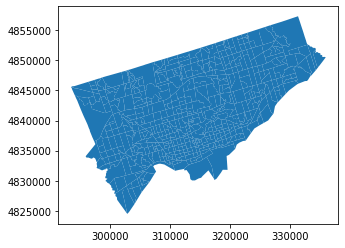

In [38]:
gdf_dem.plot(facecolor='gray')
gdf_demproj.plot()

#### NOTE:
Again, the MTM Zone 10 CSR in blue will be used going forward.

#### NOTE:
The following visualizations are grouped into three maps using different schemes to represent the same underlying data.  Hopefully this will aid in producing some insights.

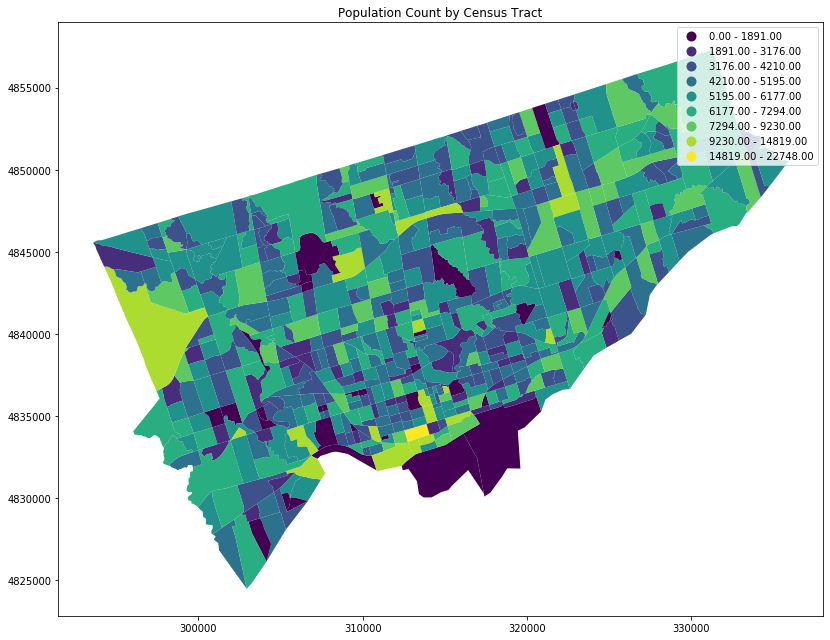

In [39]:
# View some demographic data as colour-coded map regions
# Total Population Count
gdf_demproj.plot(column="Total_Population_Count",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, \
                 legend=True);

plt.title('Population Count by Census Tract')

# Use tight layout
plt.tight_layout();

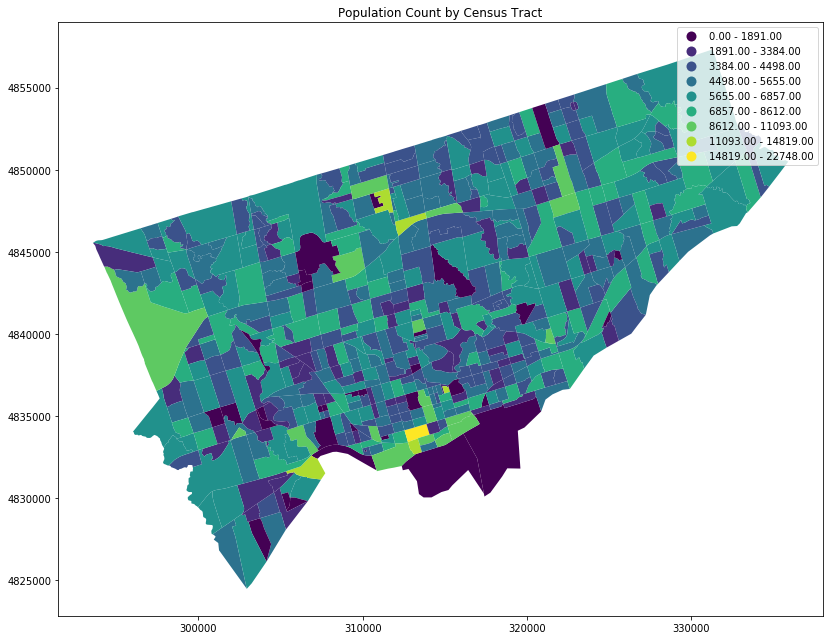

In [40]:
# View some demographic data as colour-coded map regions
# Total Population Count
gdf_demproj.plot(column="Total_Population_Count",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Population Count by Census Tract')

# Use tight layout
plt.tight_layout();

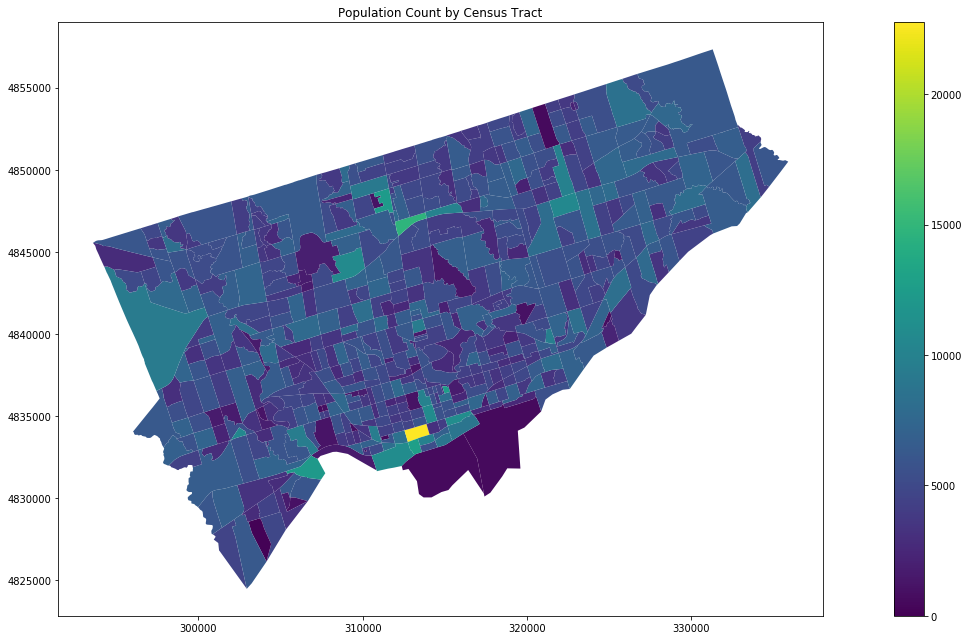

In [41]:
# View some demographic data as colour-coded map regions
# Total Population Count
gdf_demproj.plot(column="Total_Population_Count",\
                 figsize=(20,9), \
                 #scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Population Count by Census Tract')

# Use tight layout
plt.tight_layout();

#### NOTE:
While the census tracts do have a range of populations, one specific tract stands out as having a very high population (above 3rd plot in yellow).

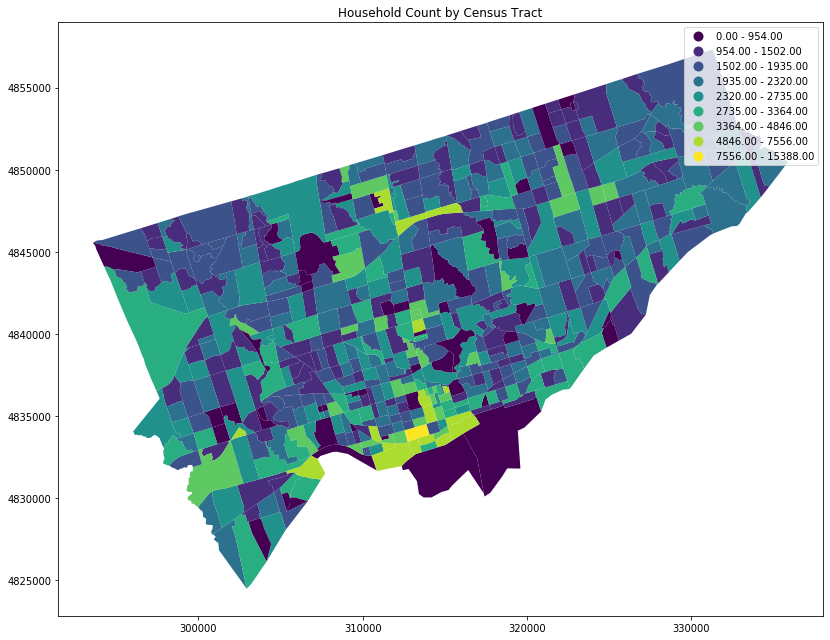

In [42]:
# View some demographic data as colour-coded map regions
# Total Household Count
gdf_demproj.plot(column="Total_Household_Count",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Household Count by Census Tract')

# Use tight layout
plt.tight_layout();

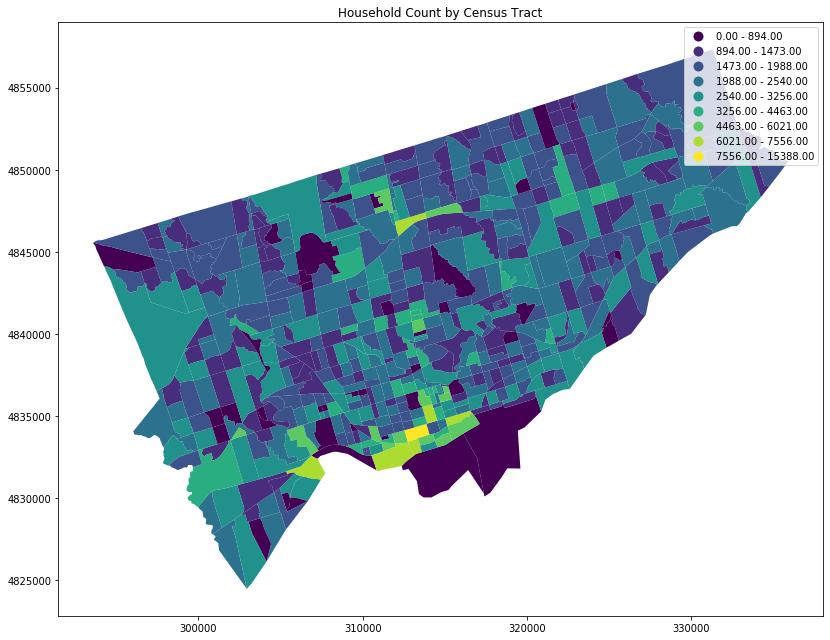

In [43]:
# View some demographic data as colour-coded map regions
# Total Household Count
gdf_demproj.plot(column="Total_Household_Count",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Household Count by Census Tract')

# Use tight layout
plt.tight_layout();

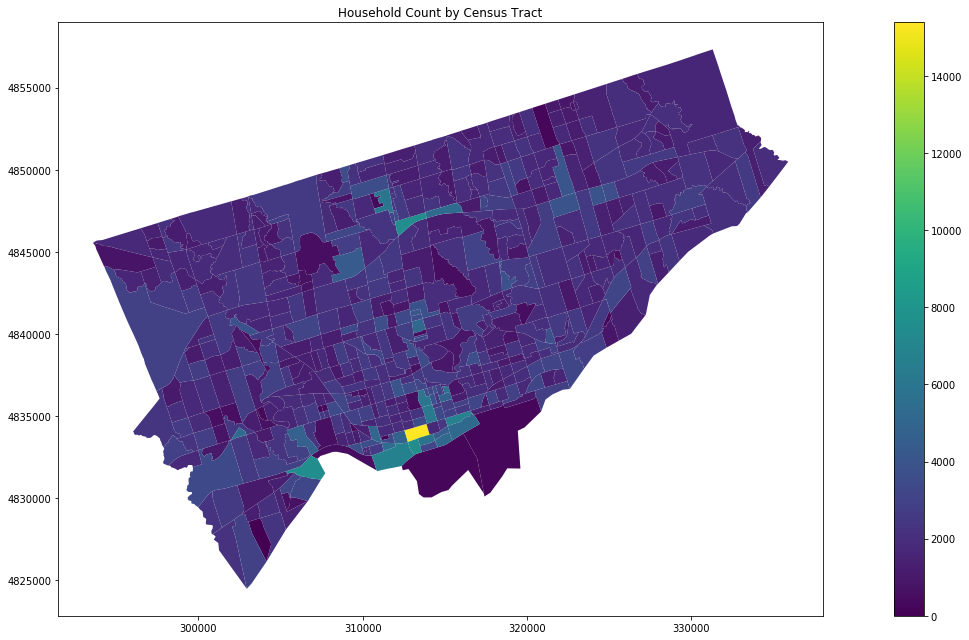

In [44]:
# View some demographic data as colour-coded map regions
# Total Household Count
gdf_demproj.plot(column="Total_Household_Count",\
                 figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Household Count by Census Tract')

# Use tight layout
plt.tight_layout();

#### NOTE:
As with the population maps previously, one census tract stands out as having a very high number of households relative to the rest of the city (above in yellow).  This indicates an area of very high density housing/appartments with many residents.

In [45]:
gdf_demproj[gdf_demproj['Total_Household_Count']>14000]

spatial_id                    name  Total_Household_Count  \
13  5350011.00  CT0011.00, Toronto, ON                15388.0   

    Total_Population_Count  Total_Income_Over_100K_Count  \
13                 22748.0                        6151.0   

    Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
13                        1460.0                     140847.11   

    Median_Household_Income_Dollars  \
13                         83229.86   

    Total_Population_Languages_No_Eng_French_Count  \
13                                           246.0   

    Total_Houshold_Mother_Tongue_Eng_Pct  Total_Current_Consumption_Dollars  \
13                               68.8133                       1.527668e+09   

    Total_Expenditure_Dollars  \
13               2.256723e+09   

                                             geometry  
13  POLYGON ((312812.4857335773 4833447.333568549,...

#### NOTE:
The yellow area has over 15,000 households that average less than 2 people per household.

#### NOTE:
Below, an Area field is added.  Future analysis relating to the presense of signs and traffic accidents per square kilometre may reveal some informative insights.

In [46]:
# Add an Area field to the demproj table for further calculations
# NOTE - MTM unit of measure is metres, so convert to Km2 for further analysis
gdf_demproj['Area'] = None
gdf_demproj['Area'] = gdf_demproj['geometry'].area / (1000 * 1000)
gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  Total_Current_Consumption_Dollars  \
0                               72.5000                       2.359562e+07   
1                               89.1566                       1.630873e+07   
2                               53.8462                       4.888142e+07   
3                               50.0513                       1.598141e+08   
4                               55.8916                       1.946197e+08   

   Total_Expenditure_Dollars  \
0               3.548888e+07   
1               2.219318e+07   
2               7.189374e+07   
3               1.887939e+08   
4               2.474892e+08   

                                            geometry       Area  
0  POLYGON ((320680.3743114723 4835111.663189559,...  13.453400  
1  POLYGON ((317005.3262185335 4832246.620448819,...  10.289987  
2  POLYGON ((310090.9919327127 4832634.009787658,...   1.751794  
3  POLYGON ((309961.8252407954 4833027.383222284,...   0.343402  
4  POLYGON ((310885.1759646178 4833459.156552648,...   0.376046

#### NOTE:
Below, the spatial_id from the demographic dataset is added to the sign and KSI datasets.

In [47]:
# Determine the demproj spatial_id of each sign in Toronto
gdf_signs['spatial_id'] = None

for index, row in gdf_demproj.iterrows():
    point_in_dem = gdf_signs.within(gdf_demproj.loc[index, 'geometry'])
    gdf_signs.loc[point_in_dem, 'spatial_id'] = gdf_demproj.loc[index, 'spatial_id']

#gdf_found_signs = gdf_signs[~gdf_signs['Ward_Found'].isnull()]
gdf_signs.head()

Sign Account Street Number  Street Name Size (LxW)  \
0       44-001     4566-4568  KINGSTON RD    10 x 20   
1       44-001     4566-4568  KINGSTON RD    10 x 20   
2       44-002          4528  KINGSTON RD    10 x 20   
3       44-002          4528  KINGSTON RD    10 x 20   
4       44-002          4528  KINGSTON RD    10 x 20   

                Location Description (if no address)  X Coordinate  \
0  On Kingston Rd. between Military Trail & Morni...     330183.18   
1  On Kingston Rd. between Military Trail & Morni...     330184.17   
2  On Kingston Rd. between Military Trail & Morni...     330055.54   
3  On Kingston Rd. between Military Trail & Morni...     330059.83   
4  On Kingston Rd. between Military Trail & Morni...     330061.23   

   Y Coordinate Sign Type Sign Technology Sign Face Direction Illumination  \
0    4848008.89    Ground          STATIC                   W         Down   
1    4848001.36    Ground          STATIC                   E         Down   
2    4847844.62      Roof          STATIC                  NE           Up   
3    4847841.82      Roof          STATIC                  NE           Up   
4    4847842.89      Roof          STATIC                  SW           Up   

  Sign Owner Sign Owner Identifier  \
0   PATTISON                 5364A   
1   PATTISON                 5364B   
2        CBS                  1633   
3        CBS                  1634   
4        CBS                  1631   

                           Context Picture Hyperlink  Ward_ID  \
0  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
1  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
2  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
3  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   
4  http://maps.live.com/default.aspx?v=2&FORM=LML...       44   

                       geometry Ward_Found  spatial_id  
0  POINT (330183.18 4848008.89)         44  5350359.00  
1  POINT (330184.17 4848001.36)         44  5350359.00  
2  POINT (330055.54 4847844.62)         44  5350359.00  
3  POINT (330059.83 4847841.82)         44  5350359.00  
4  POINT (330061.23 4847842.89)         44  5350359.00

In [48]:
# Determine the demproj spatial_id of each KSI point in Toronto
gdf_ksiproj['spatial_id'] = None

for index, row in gdf_demproj.iterrows():
    point_in_dem = gdf_ksiproj.within(gdf_demproj.loc[index, 'geometry'])
    gdf_ksiproj.loc[point_in_dem, 'spatial_id'] = gdf_demproj.loc[index, 'spatial_id']

#gdf_found_signs = gdf_signs[~gdf_signs['Ward_Found'].isnull()]
gdf_ksiproj.head()

X          Y    Index_      ACCNUM  YEAR                      DATE  \
0 -79.454730  43.675280  80771254  7001005616  2017  2017-06-03T04:00:00.000Z   
1 -79.520641  43.770049  80783528  7001744141  2017  2017-09-25T04:00:00.000Z   
2 -79.520641  43.770049  80783529  7001744141  2017  2017-09-25T04:00:00.000Z   
3 -79.286601  43.751868  80790062  7003112978  2017  2017-12-01T05:00:00.000Z   
4 -79.286601  43.751868  80790894  7003112978  2017  2017-12-01T05:00:00.000Z   

   TIME  Hour         STREET1        STREET2  ... ALCOHOL DISABILITY Division  \
0  2330    23  ST CLAIR AVE W   CALEDONIA RD  ...                          13   
1  2330    23    4673 JANE ST                 ...                          31   
2  2330    23    4673 JANE ST                 ...                          31   
3  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                          41   
4  2330    23   BIRCHMOUNT RD  MERRYFIELD DR  ...                          41   

   Ward_Name  Ward_ID Hood_ID Hood_Name ObjectId  \
0        NaN      NaN      92       NaN    12001   
1        NaN      NaN      24       NaN    12002   
2        NaN      NaN      24       NaN    12003   
3        NaN      NaN     126       NaN    12004   
4        NaN      NaN     126       NaN    12005   

                                      geometry  spatial_id  
0    POINT (308450.313492727 4837260.25309587)  5350110.00  
1  POINT (303138.2495327648 4847787.894378964)  5350316.04  
2  POINT (303138.2495327648 4847787.894378964)  5350316.04  
3   POINT (321985.374990024 4845789.974195491)  5350371.00  
4   POINT (321985.374990024 4845789.974195491)  5350371.00  

[5 rows x 59 columns]

#### NOTE:
Below, the count of signs and traffic accidents is summarized by census tract in the demographic dataset.  The spatial_id field is used to link these datasets to retrieve the counts.

In [49]:
# Add a column to the demographic dataframe to track the total number of signs in each region
gdf_demproj['Total_Sign_Count'] = None 

for index, row in gdf_demproj.iterrows():
    gdf_demproj.loc[index, 'Total_Sign_Count'] = gdf_signs.loc[gdf_signs['spatial_id']==row['spatial_id'],'spatial_id'].count()

gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  Total_Current_Consumption_Dollars  \
0                               72.5000                       2.359562e+07   
1                               89.1566                       1.630873e+07   
2                               53.8462                       4.888142e+07   
3                               50.0513                       1.598141e+08   
4                               55.8916                       1.946197e+08   

   Total_Expenditure_Dollars  \
0               3.548888e+07   
1               2.219318e+07   
2               7.189374e+07   
3               1.887939e+08   
4               2.474892e+08   

                                            geometry       Area  \
0  POLYGON ((320680.3743114723 4835111.663189559,...  13.453400   
1  POLYGON ((317005.3262185335 4832246.620448819,...  10.289987   
2  POLYGON ((310090.9919327127 4832634.009787658,...   1.751794   
3  POLYGON ((309961.8252407954 4833027.383222284,...   0.343402   
4  POLYGON ((310885.1759646178 4833459.156552648,...   0.376046   

   Total_Sign_Count  
0                90  
1                 0  
2                 7  
3                 8  
4                10

In [50]:
# Add a column to the demographic dataframe to track the total number of traffic accidents in each region
gdf_demproj['Traffic_Accident_Count'] = None 

for index, row in gdf_demproj.iterrows():
    gdf_demproj.loc[index, 'Traffic_Accident_Count'] = gdf_ksiproj.loc[gdf_ksiproj['spatial_id']==row['spatial_id'],'spatial_id'].count()

gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  Total_Current_Consumption_Dollars  \
0                               72.5000                       2.359562e+07   
1                               89.1566                       1.630873e+07   
2                               53.8462                       4.888142e+07   
3                               50.0513                       1.598141e+08   
4                               55.8916                       1.946197e+08   

   Total_Expenditure_Dollars  \
0               3.548888e+07   
1               2.219318e+07   
2               7.189374e+07   
3               1.887939e+08   
4               2.474892e+08   

                                            geometry       Area  \
0  POLYGON ((320680.3743114723 4835111.663189559,...  13.453400   
1  POLYGON ((317005.3262185335 4832246.620448819,...  10.289987   
2  POLYGON ((310090.9919327127 4832634.009787658,...   1.751794   
3  POLYGON ((309961.8252407954 4833027.383222284,...   0.343402   
4  POLYGON ((310885.1759646178 4833459.156552648,...   0.376046   

   Total_Sign_Count  Traffic_Accident_Count  
0                90                      68  
1                 0                       0  
2                 7                     135  
3                 8                      22  
4                10                      16

#### NOTE:

The following visualizations are grouped into three maps using different schemes to represent the same underlying data. Hopefully this will aid in producing some insights.


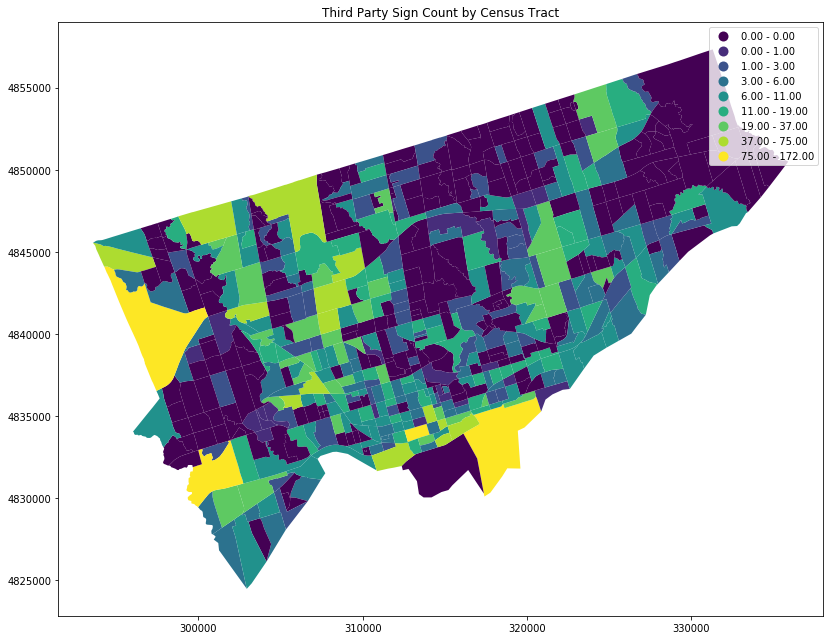

In [51]:
# View some demographic data as colour-coded map regions
# Total Sign Count
gdf_demproj.plot(column="Total_Sign_Count",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count by Census Tract')

# Use tight layout
plt.tight_layout();

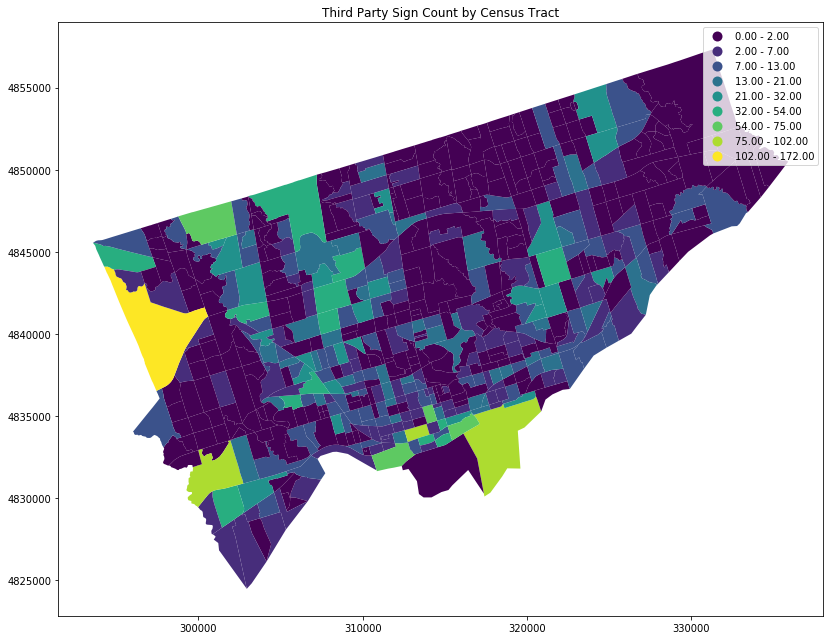

In [52]:
# View some demographic data as colour-coded map regions
# Total Sign Count
gdf_demproj.plot(column="Total_Sign_Count",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count by Census Tract')

# Use tight layout
plt.tight_layout();

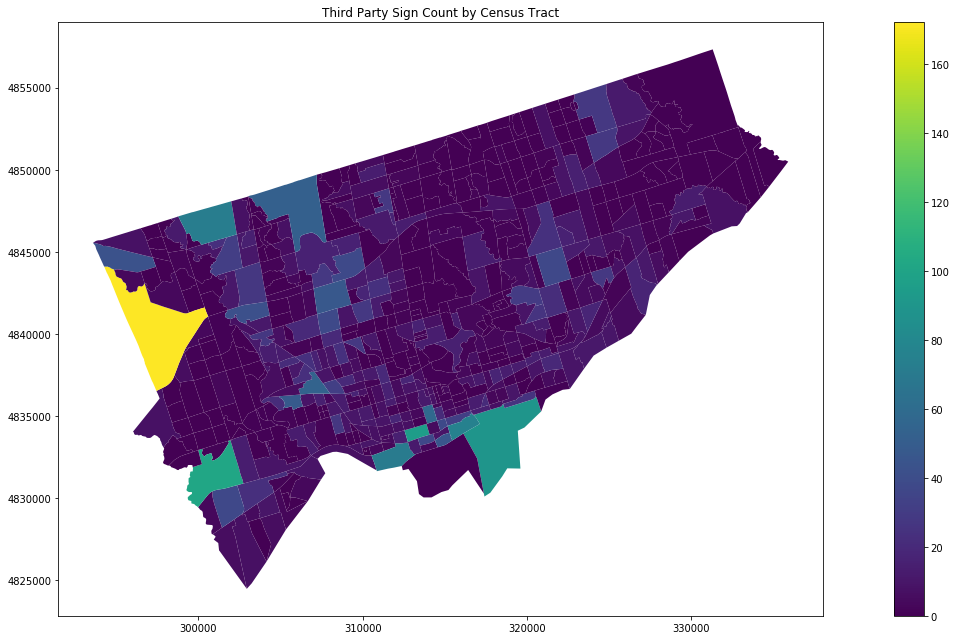

In [53]:
# View some demographic data as colour-coded map regions
# Total Sign Count
gdf_demproj.plot(column="Total_Sign_Count",\
                 figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count by Census Tract')

# Use tight layout
plt.tight_layout();

#### NOTE:
Higher counts are seen in the south end of the city, but a very high count of signs (over 160) is observed in the north-west section.

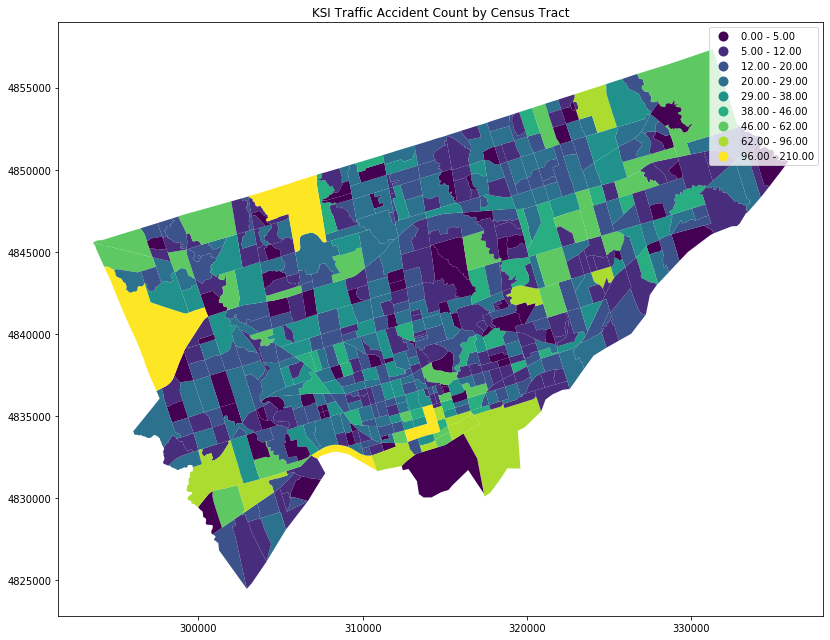

In [54]:
# View some demographic data as colour-coded map regions
# Traffic Accident Count
gdf_demproj.plot(column="Traffic_Accident_Count",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accident Count by Census Tract')

# Use tight layout
plt.tight_layout();

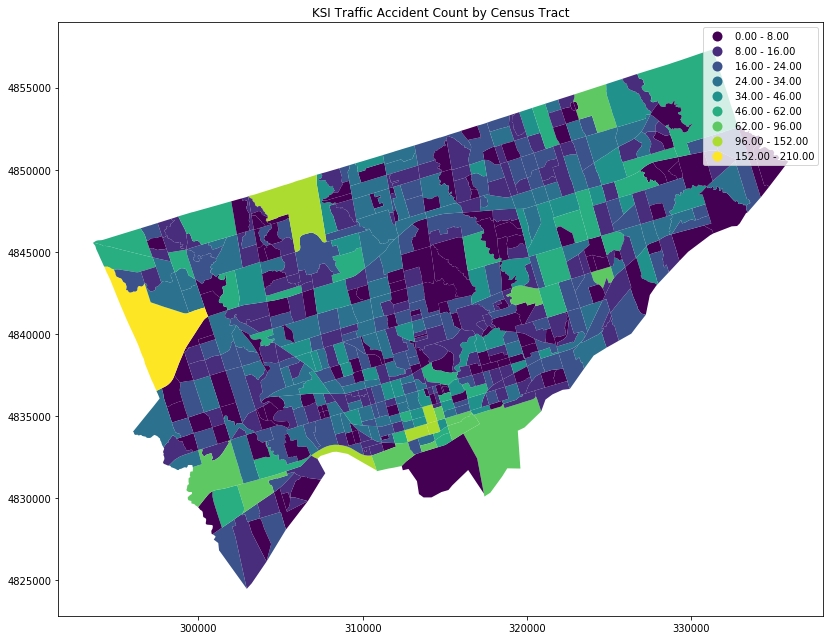

In [55]:
# View some demographic data as colour-coded map regions
# Traffic Accident Count
gdf_demproj.plot(column="Traffic_Accident_Count",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accident Count by Census Tract')

# Use tight layout
plt.tight_layout();

In [56]:
# View some demographic data as colour-coded map regions
# Traffic Accident Count
gdf_demproj.plot(column="Traffic_Accident_Count",\
                 figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accident Count by Census Tract')

# Use tight layout
plt.tight_layout();

#### NOTE:
Similarly with signs, the number of traffic accidents is high in the south-central to south-western heart of the city with another notable area on the north edge of the city (in brighter green above).  Also, the same tract that had the very high count of signs also shows a relatively high count of traffic accidents (yellow region, over 200 accidents).

However, given the different size of each tract, the average number of signs and traffic accidents per square kilometer should be examined.

In [57]:
# Add an Area field to the demproj table for further calculations
# NOTE - MTM unit of measure is metres, so convert to Km2 for further analysis
gdf_demproj['Signs_Per_Square_Km'] = None
gdf_demproj['Signs_Per_Square_Km'] = gdf_demproj['Total_Sign_Count'] / gdf_demproj['Area']

gdf_demproj['Traffic_Accidents_Per_Square_Km'] = None
gdf_demproj['Traffic_Accidents_Per_Square_Km'] = gdf_demproj['Traffic_Accident_Count'] / gdf_demproj['Area']

gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  Total_Current_Consumption_Dollars  \
0                               72.5000                       2.359562e+07   
1                               89.1566                       1.630873e+07   
2                               53.8462                       4.888142e+07   
3                               50.0513                       1.598141e+08   
4                               55.8916                       1.946197e+08   

   Total_Expenditure_Dollars  \
0               3.548888e+07   
1               2.219318e+07   
2               7.189374e+07   
3               1.887939e+08   
4               2.474892e+08   

                                            geometry       Area  \
0  POLYGON ((320680.3743114723 4835111.663189559,...  13.453400   
1  POLYGON ((317005.3262185335 4832246.620448819,...  10.289987   
2  POLYGON ((310090.9919327127 4832634.009787658,...   1.751794   
3  POLYGON ((309961.8252407954 4833027.383222284,...   0.343402   
4  POLYGON ((310885.1759646178 4833459.156552648,...   0.376046   

   Total_Sign_Count  Traffic_Accident_Count  Signs_Per_Square_Km  \
0                90                      68             6.689759   
1                 0                       0             0.000000   
2                 7                     135             3.995903   
3                 8                      22            23.296331   
4                10                      16            26.592498   

   Traffic_Accidents_Per_Square_Km  
0                         5.054484  
1                         0.000000  
2                        77.063849  
3                        64.064909  
4                        42.547996

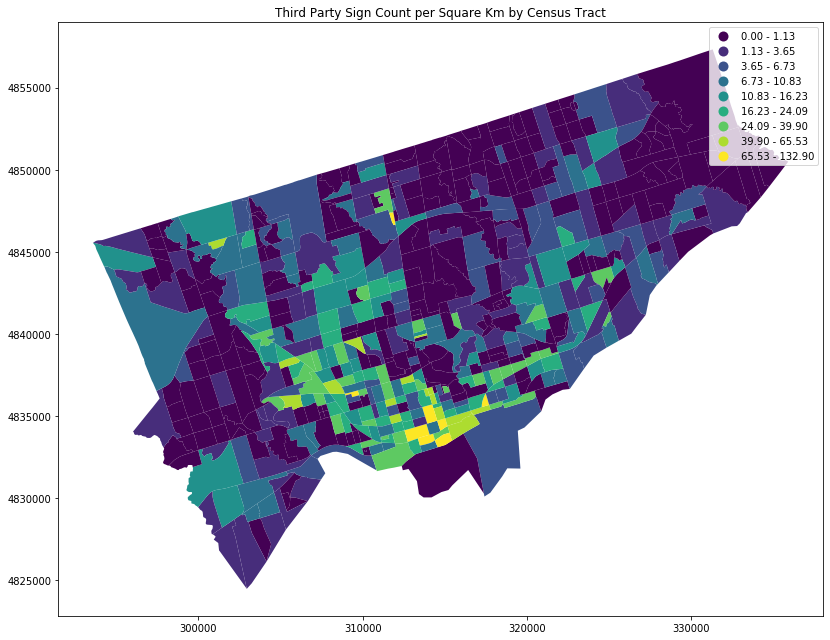

In [58]:
# View some demographic data as colour-coded map regions
# Total Sign Count per Square Km
gdf_demproj.plot(column="Signs_Per_Square_Km",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

In [59]:
# View some demographic data as colour-coded map regions
# Total Sign Count per Square Km
gdf_demproj.plot(column="Signs_Per_Square_Km",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

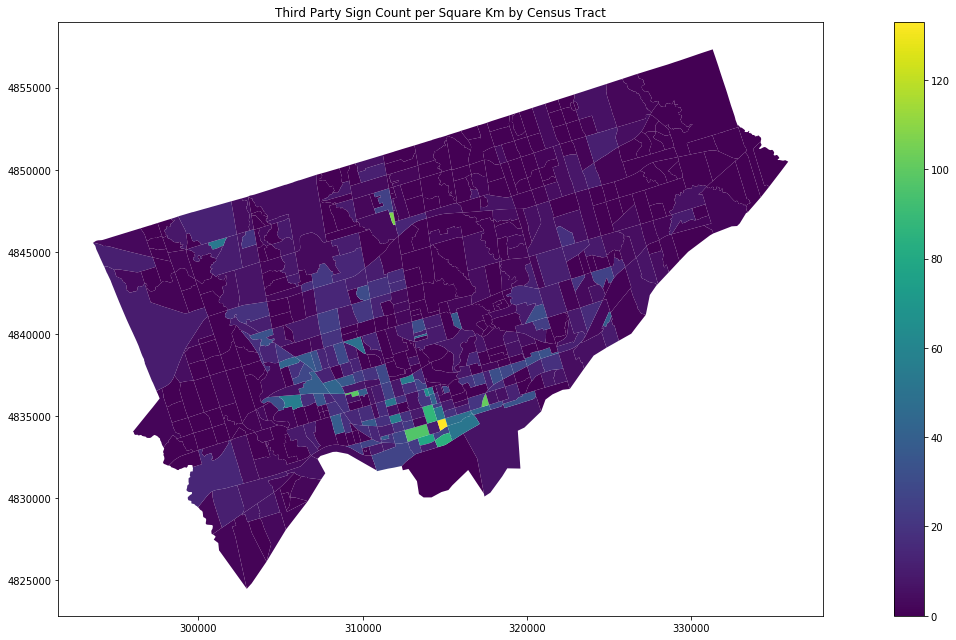

In [60]:
# View some demographic data as colour-coded map regions
# Total Sign Count per Square Km
gdf_demproj.plot(column="Signs_Per_Square_Km",\
                 figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('Third Party Sign Count per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

### NOTE:
This seems to give a more accurate representation of the number of signs in each tract.  As expected, the south-central area of Toronto has the highest clustering of signs.

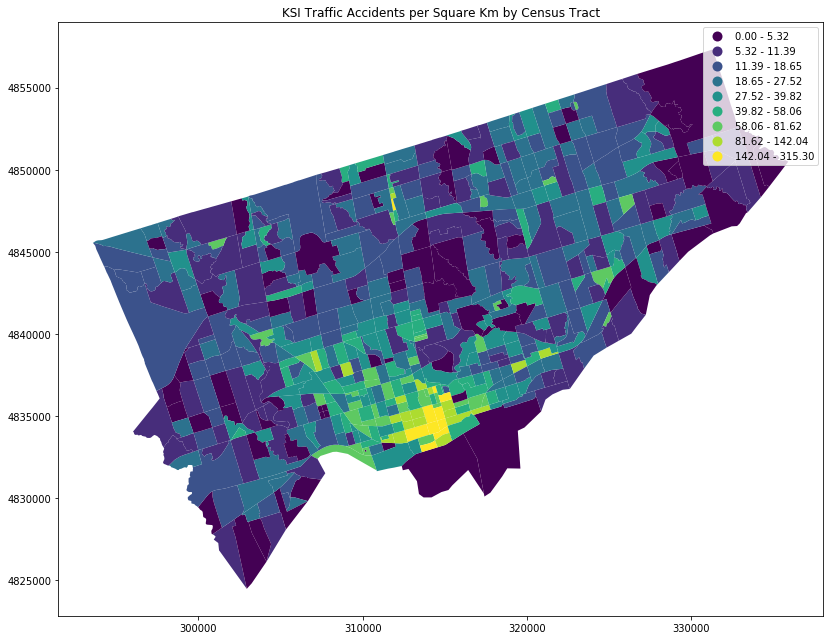

In [61]:
# View some demographic data as colour-coded map regions
# Traffic Accidents per Square Km Count
gdf_demproj.plot(column="Traffic_Accidents_Per_Square_Km",\
                 figsize=(20,9), \
                 scheme="Natural_Breaks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accidents per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

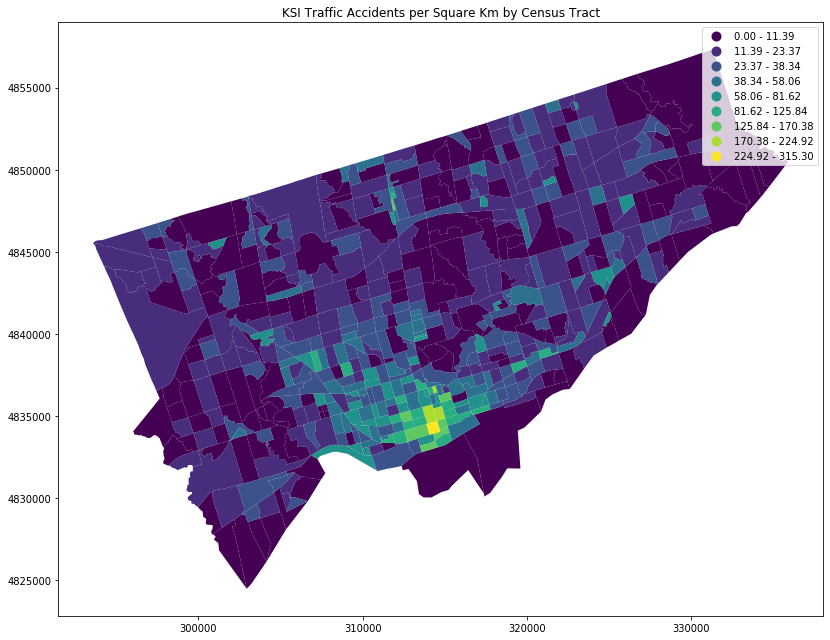

In [62]:
# View some demographic data as colour-coded map regions
# Traffic Accidents per Square Km
gdf_demproj.plot(column="Traffic_Accidents_Per_Square_Km",\
                 figsize=(20,9), \
                 scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accidents per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

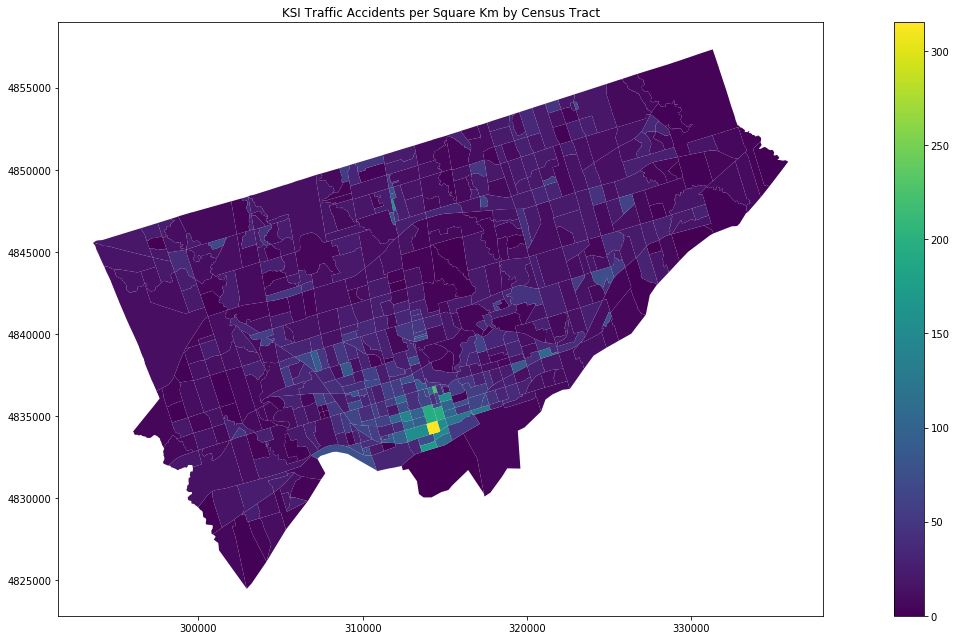

In [63]:
# View some demographic data as colour-coded map regions
# Traffic Accidents per Square Km
gdf_demproj.plot(column="Traffic_Accidents_Per_Square_Km",\
                 figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);

plt.title('KSI Traffic Accidents per Square Km by Census Tract')

# Use tight layout
plt.tight_layout();

### NOTE:
As noticed with the signs per square kilometer, the number of traffic accidents per square kilometer also seems to cluster in the south-central areas of Toronto.

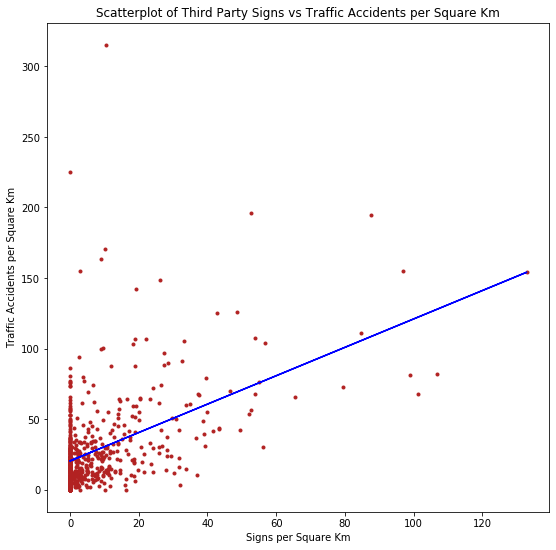

In [64]:
f, ax = plt.subplots(1, figsize = (9,9))

plt.plot(gdf_demproj['Signs_Per_Square_Km'], \
         gdf_demproj['Traffic_Accidents_Per_Square_Km'], \
         '.', \
        color='firebrick')

# Fit a line 
b, a = np.polyfit(gdf_demproj['Signs_Per_Square_Km'], \
                  gdf_demproj['Traffic_Accidents_Per_Square_Km'], 1)

plt.plot(gdf_demproj['Signs_Per_Square_Km'], \
         a+b*gdf_demproj['Signs_Per_Square_Km'], 'b')
plt.title('Scatterplot of Third Party Signs vs Traffic Accidents per Square Km')
plt.ylabel('Traffic Accidents per Square Km')
plt.xlabel('Signs per Square Km')
plt.show()

### Comparitive Analysis - Do Signs/Accidents Appear in Special Demographic Regions?

In [65]:
gdf_demproj.mean()

Total_Household_Count                             2.096626e+03
Total_Population_Count                            5.128080e+03
Total_Income_Over_100K_Count                      6.121364e+02
Total_Income_Over_250K_Count                      1.439003e+02
Avg_Household_Income_Dollars                      1.197232e+05
Median_Household_Income_Dollars                   6.803947e+04
Total_Population_Languages_No_Eng_French_Count    2.567238e+02
Total_Houshold_Mother_Tongue_Eng_Pct              5.209979e+01
Total_Current_Consumption_Dollars                 1.796879e+08
Total_Expenditure_Dollars                         2.612741e+08
Area                                              1.163883e+00
Total_Sign_Count                                  7.017483e+00
Traffic_Accident_Count                            2.124825e+01
Signs_Per_Square_Km                               8.646984e+00
Traffic_Accidents_Per_Square_Km                   2.900491e+01
dtype: float64

#### NOTE:
Below, identify which tracts have above average counts for the following categories:

* Household count
* Population count
* Total income over \\$100K count
* Total income over \\$250K count
* Average household income
* Median household income
* Total population that does not speak English or French count
* Total population with English as their mother tongue percentage
* Total current consumption dollars (consumer spending)
* Total expenditure dollars (household expenditures)

Visualize these results, and overlay the location points of third party signs for reference.

In [66]:
# Do signs appear where there is above average household count, population, 
# income, consumption, etc.?
gdf_demproj['Above_Avg_Household_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Household_Count'] > gdf_demproj['Total_Household_Count'].mean(),\
                'Above_Avg_Household_Count'] = 1

gdf_demproj['Above_Avg_Population_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Population_Count'] > gdf_demproj['Total_Population_Count'].mean(),\
                'Above_Avg_Population_Count'] = 1

gdf_demproj['Above_Avg_Over_100K_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Income_Over_100K_Count'] > gdf_demproj['Total_Income_Over_100K_Count'].mean(),\
                'Above_Avg_Over_100K_Count'] = 1

gdf_demproj['Above_Avg_Over_250K_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Income_Over_250K_Count'] > gdf_demproj['Total_Income_Over_250K_Count'].mean(),\
                'Above_Avg_Over_250K_Count'] = 1

gdf_demproj['Above_Avg_AvgHousehold_Income_Dollars'] = 0
gdf_demproj.loc[gdf_demproj['Avg_Household_Income_Dollars'] > gdf_demproj['Avg_Household_Income_Dollars'].mean(),\
                'Above_Avg_AvgHousehold_Income_Dollars'] = 1

gdf_demproj['Above_Avg_MedHousehold_Income_Dollars'] = 0
gdf_demproj.loc[gdf_demproj['Median_Household_Income_Dollars'] > gdf_demproj['Median_Household_Income_Dollars'].mean(),\
                'Above_Avg_MedHousehold_Income_Dollars'] = 1

gdf_demproj['Above_Avg_Pop_No_Eng_Fr_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Population_Languages_No_Eng_French_Count'] > gdf_demproj['Total_Population_Languages_No_Eng_French_Count'].mean(),\
                'Above_Avg_Pop_No_Eng_Fr_Count'] = 1

gdf_demproj['Above_Avg_Pop_Eng_First_Count'] = 0
gdf_demproj.loc[gdf_demproj['Total_Houshold_Mother_Tongue_Eng_Pct'] > gdf_demproj['Total_Houshold_Mother_Tongue_Eng_Pct'].mean(),\
                'Above_Avg_Pop_Eng_First_Count'] = 1

gdf_demproj['Above_Avg_Consumption_Dollars'] = 0
gdf_demproj.loc[gdf_demproj['Total_Current_Consumption_Dollars'] > gdf_demproj['Total_Current_Consumption_Dollars'].mean(),\
                'Above_Avg_Consumption_Dollars'] = 1

gdf_demproj['Above_Avg_Expenditure_Dollars'] = 0
gdf_demproj.loc[gdf_demproj['Total_Expenditure_Dollars'] > gdf_demproj['Total_Expenditure_Dollars'].mean(),\
                'Above_Avg_Expenditure_Dollars'] = 1


gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Household_Count  \
0                               72.5000  ...                          0   
1                               89.1566  ...                          0   
2                               53.8462  ...                          0   
3                               50.0513  ...                          1   
4                               55.8916  ...                          1   

   Above_Avg_Population_Count Above_Avg_Over_100K_Count  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           1                         0   
4                           1                         0   

   Above_Avg_Over_250K_Count  Above_Avg_AvgHousehold_Income_Dollars  \
0                          0                                      1   
1                          0                                      0   
2                          0                                      1   
3                          0                                      0   
4                          0                                      0   

   Above_Avg_MedHousehold_Income_Dollars  Above_Avg_Pop_No_Eng_Fr_Count  \
0                                      1                              0   
1                                      1                              0   
2                                      1                              0   
3                                      0                              1   
4                                      0                              1   

   Above_Avg_Pop_Eng_First_Count  Above_Avg_Consumption_Dollars  \
0                              1                              0   
1                              1                              0   
2                              1                              0   
3                              0                              0   
4                              1                              1   

   Above_Avg_Expenditure_Dollars  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 28 columns]

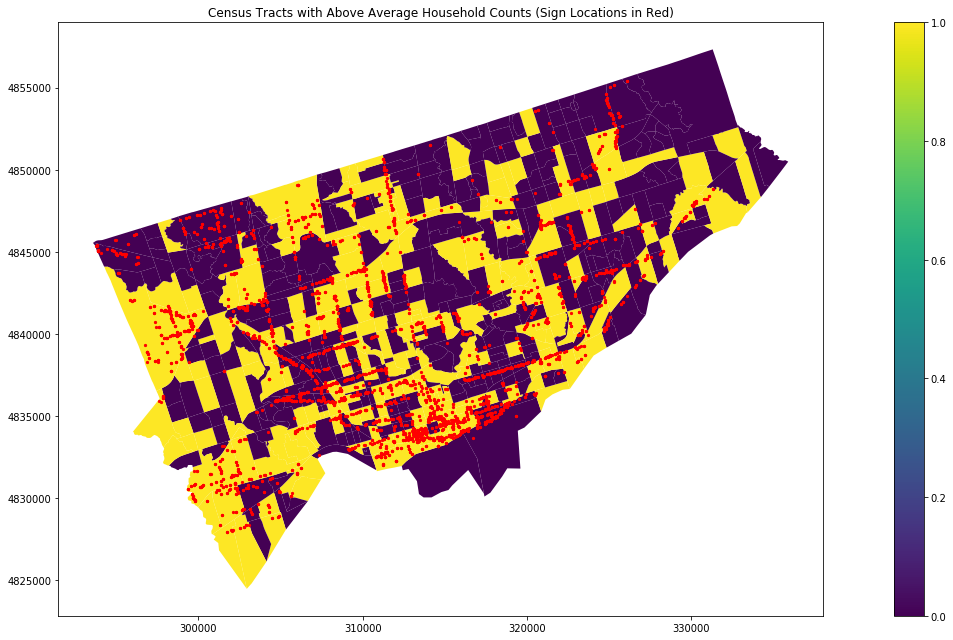

In [67]:
# Plot the signs on the above averate household map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Household_Count",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Household Counts (Sign Locations in Red)')


plt.tight_layout();

In [68]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_households = gdf_demproj.loc[gdf_demproj['Above_Avg_Household_Count'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average number of housholds:  ', total_signs_above_avg_households)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_households/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average number of housholds:   2265
Percentage of total (plotted) signs:   0.5642750373692078


#### NOTE:
The yellow areas indicate census tracts with above average household counts.  The number of signs in these areas represent 56.4% of the total number of signs in the city.  There doesn't appear to be a strong relationship here between sign location and number of households.

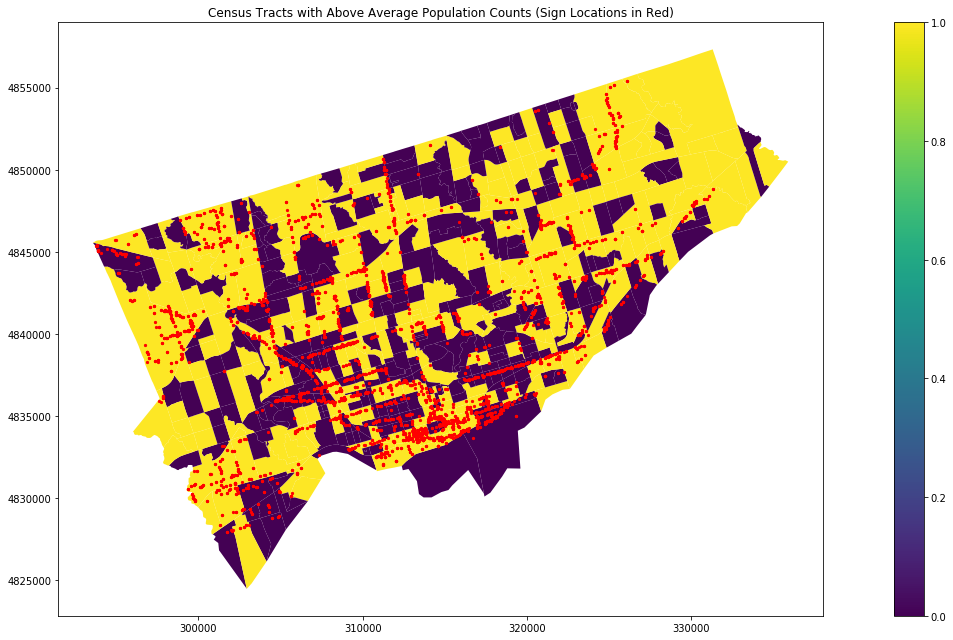

In [69]:
# Plot the signs on the above averate population map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Population_Count",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Population Counts (Sign Locations in Red)')


plt.tight_layout();

In [70]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_pop = gdf_demproj.loc[gdf_demproj['Above_Avg_Population_Count'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average population:  ', total_signs_above_avg_pop)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_pop/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average population:   2463
Percentage of total (plotted) signs:   0.6136023916292974


#### NOTE:
The yellow areas indicate census tracts with above average population counts.  The number of signs in these areas represent 61.4% of the total number of signs in the city.  The relationship here between sign location and population appears to be a bit stronger.

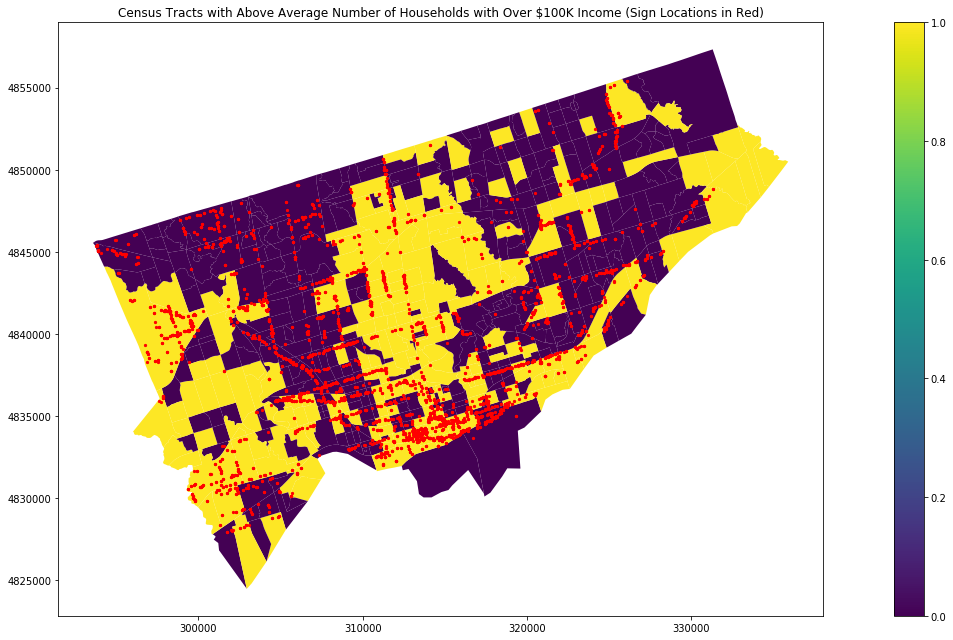

In [71]:
# Plot the signs on the above average # of households with over $100K income map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Over_100K_Count",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Number of Households with Over $100K Income (Sign Locations in Red)')


plt.tight_layout();

In [72]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_100K = gdf_demproj.loc[gdf_demproj['Above_Avg_Over_100K_Count'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average number of over $100K household incomes:  ', total_signs_above_avg_100K)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_100K/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average number of over $100K household incomes:   1990
Percentage of total (plotted) signs:   0.4957648231190832


#### NOTE:
The yellow areas indicate census tracts with above average number of households with over \\$100K income.  The number of signs in these areas represent 49.5% of the total number of signs in the city.   There doesn't appear to be a strong relationship here between sign location and number of households with over $100K income.

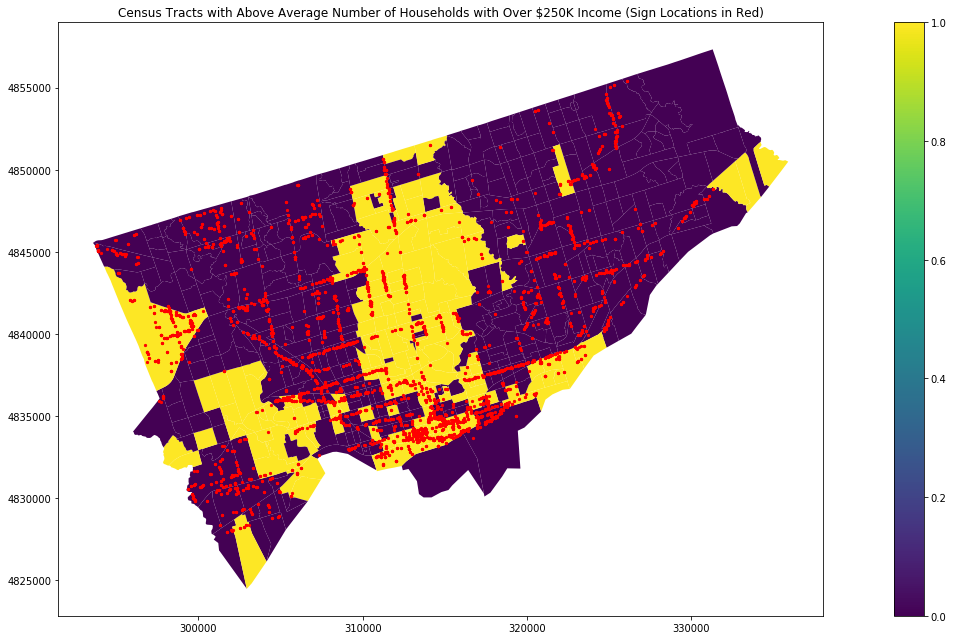

In [73]:
# Plot the signs on the above average # of households with over $250K income map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Over_250K_Count",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Number of Households with Over $250K Income (Sign Locations in Red)')


plt.tight_layout();

In [74]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_250K = gdf_demproj.loc[gdf_demproj['Above_Avg_Over_250K_Count'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average number of over $250K household incomes:  ', total_signs_above_avg_250K)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_250K/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average number of over $250K household incomes:   1513
Percentage of total (plotted) signs:   0.3769307424015944


#### NOTE:
The yellow areas indicate census tracts with above average number of households with over \\$250K income.  The number of signs in these areas represent 37.7% of the total number of signs in the city.   There appears to be a negative relationship here as more signs appear in areas with fewer households with over \\$250K income.

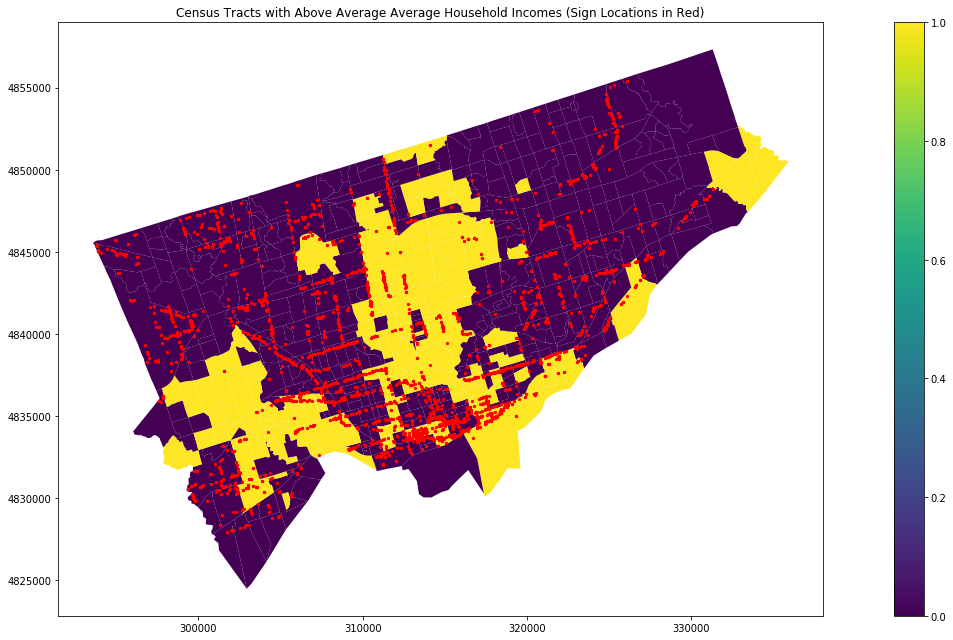

In [75]:
# Plot the signs on the above average average-household income map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_AvgHousehold_Income_Dollars",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Average Household Incomes (Sign Locations in Red)')


plt.tight_layout();

In [76]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_income = gdf_demproj.loc[gdf_demproj['Above_Avg_AvgHousehold_Income_Dollars'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average average household income:  ', total_signs_above_avg_income)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_income/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average average household income:   1055
Percentage of total (plotted) signs:   0.2628300946686597


#### NOTE:
The yellow areas indicate census tracts with above average average household income.  The number of signs in these areas represent 26.3% of the total number of signs in the city.   There appears to be a negative relationship here as more signs appear in areas with households with less than average household income.

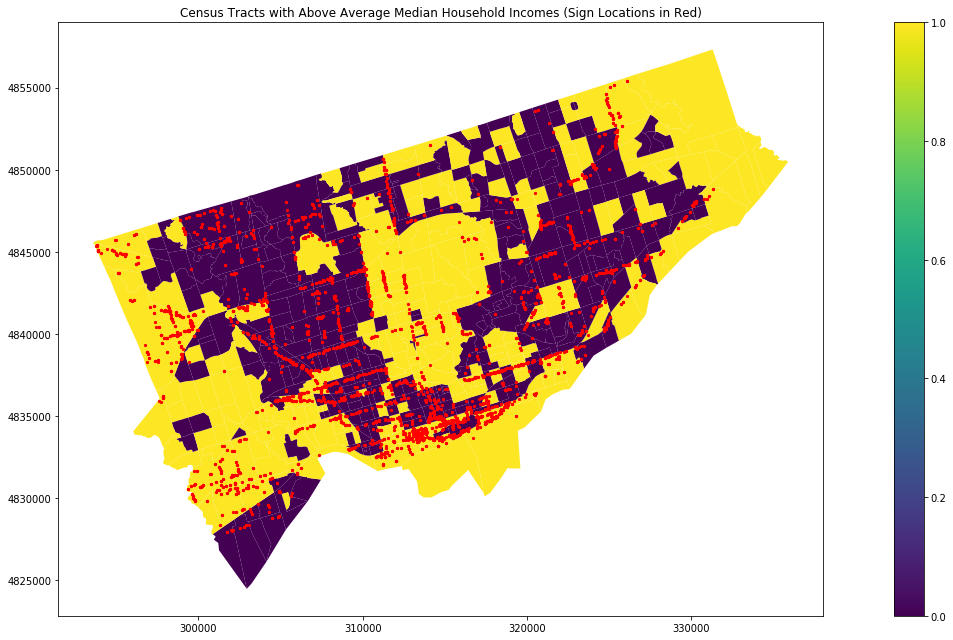

In [77]:
# Plot the signs on the above average median household income map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_MedHousehold_Income_Dollars",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Median Household Incomes (Sign Locations in Red)')


plt.tight_layout();

In [78]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_med_income = gdf_demproj.loc[gdf_demproj['Above_Avg_MedHousehold_Income_Dollars'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average median household income:  ', total_signs_above_med_income)
print('Percentage of total (plotted) signs:  ', total_signs_above_med_income/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average median household income:   1802
Percentage of total (plotted) signs:   0.44892874937717986


#### NOTE:
The yellow areas indicate census tracts with above average average household income.  The number of signs in these areas represent 44.9% of the total number of signs in the city.   There appears to be only a small negative relationship here as more signs appear in areas with households with less than average median household income.

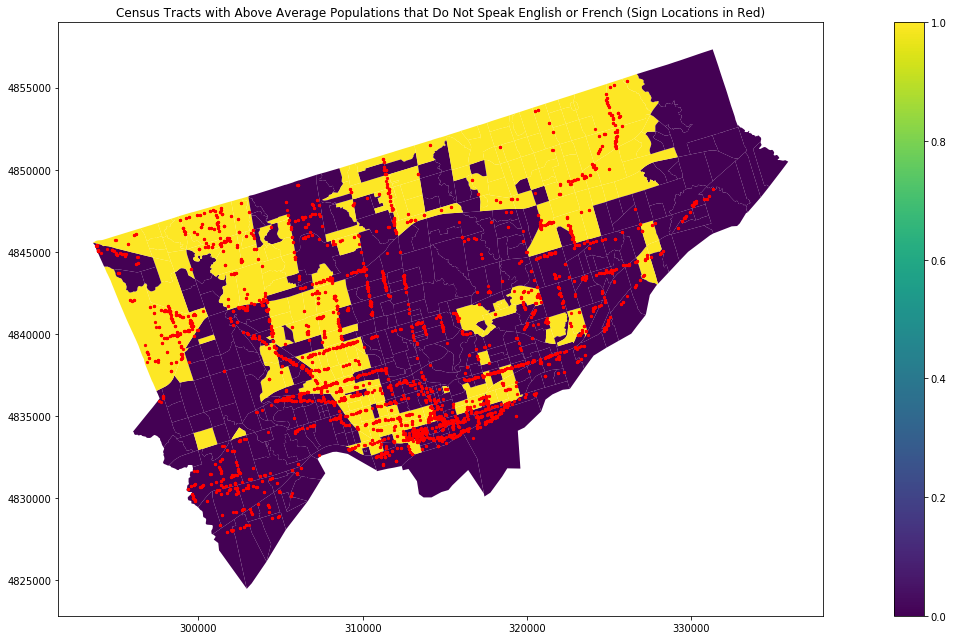

In [79]:
# Plot the signs on the above average population who do not speak 
# English or French map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Pop_No_Eng_Fr_Count",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Populations that Do Not Speak English or French (Sign Locations in Red)')


plt.tight_layout();

In [80]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_no_eng_fr = gdf_demproj.loc[gdf_demproj['Above_Avg_Pop_No_Eng_Fr_Count'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average population who do not speak English or French:  ', total_signs_above_no_eng_fr)
print('Percentage of total (plotted) signs:  ', total_signs_above_no_eng_fr/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average population who do not speak English or French:   1536
Percentage of total (plotted) signs:   0.38266068759342303


#### NOTE:
The yellow areas indicate census tracts with above average population who do not speak English or French.  The number of signs in these areas represent 38.3% of the total number of signs in the city.   There appears to be a negative relationship here as more signs appear in areas with households that speak English or French.  Given Toronto's renowned reputation as a multicultural hub, it would be easier for advertisers who use only English and French in their ads to post signs in areas known to be populated with English or French speakers than it would be to attempt to advertise in each language spoken in the various cultural pockets throughout the city.

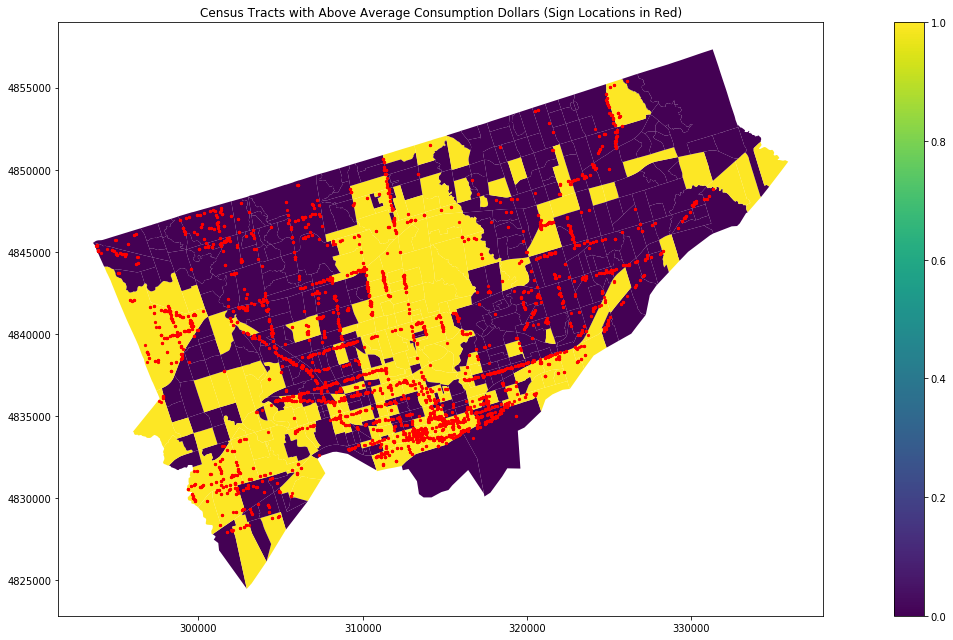

In [81]:
# Plot the signs on the above average consumption dollars map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Consumption_Dollars",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Consumption Dollars (Sign Locations in Red)')


plt.tight_layout();

In [82]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_consumption = gdf_demproj.loc[gdf_demproj['Above_Avg_Consumption_Dollars'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average consumption dollars:  ', total_signs_above_avg_consumption)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_consumption/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average consumption dollars:   1839
Percentage of total (plotted) signs:   0.4581464872944694


#### NOTE:
The yellow areas indicate census tracts with above average household consumption dollars.  The number of signs in these areas represent 45.8% of the total number of signs in the city.   There appears to be a slight negative relationship here as more signs appear in areas with households that do not have above average consumption dollars.

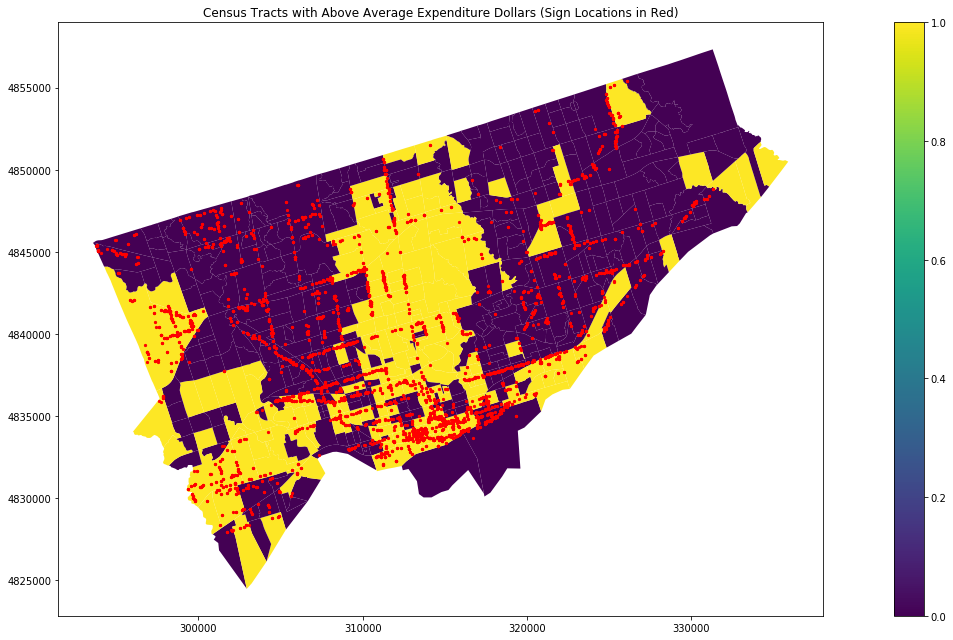

In [83]:
# Plot the signs on the above average expenditure dollars map
fig, ax = plt.subplots(figsize=(20,9))

gdf_demproj.plot(ax=ax, \
                 column="Above_Avg_Expenditure_Dollars",\
                 #figsize=(20,9), \
                 #scheme="Fisher_Jenks", \
                 k=9, \
                 #cmap="RdYlBu", \
                 linewidth=0, 
                 legend=True);
gdf_found_signs.plot(ax=ax, color='red', markersize=5);

plt.title('Census Tracts with Above Average Expenditure Dollars (Sign Locations in Red)')


plt.tight_layout();

In [84]:
total_signs = gdf_demproj['Total_Sign_Count'].sum()
total_signs_above_avg_expenditure = gdf_demproj.loc[gdf_demproj['Above_Avg_Expenditure_Dollars'] == 1,'Total_Sign_Count'].sum()
print('Total (plotted) signs in Toronto:  ', total_signs)
print('Total (plotted) signs found in areas with above average expenditure dollars:  ', total_signs_above_avg_expenditure)
print('Percentage of total (plotted) signs:  ', total_signs_above_avg_expenditure/total_signs)

Total (plotted) signs in Toronto:   4014
Total (plotted) signs found in areas with above average expenditure dollars:   1828
Percentage of total (plotted) signs:   0.45540607872446437


#### NOTE:
The yellow areas indicate census tracts with above average household expenditure dollars.  The number of signs in these areas represent 45.5% of the total number of signs in the city.   There appears to be a slight negative relationship here as more signs appear in areas with households that do not have above average expenditure dollars.

# Data Modeling 

Using this tutorial as a reference:  http://darribas.org/gds_scipy16/ipynb_md/04_esda.html
    
An attempt will be made to use Exploratory Spatial Data Analysis as a took to examine the similarities between tracts in Toronto as they relate to third-party signs and traffic accidents.    

In [85]:
import geopandas as gpd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysal.viz.mapclassify as mc  # <-- needed for Quantiles
from pysal.viz.splot import mapping as maps

C:\Users\Mills\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
C:\Users\Mills\Anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:96: UserWarning: Warning: setting k to 7
  Warn('Warning: setting k to %d' % k_q, UserWarning)


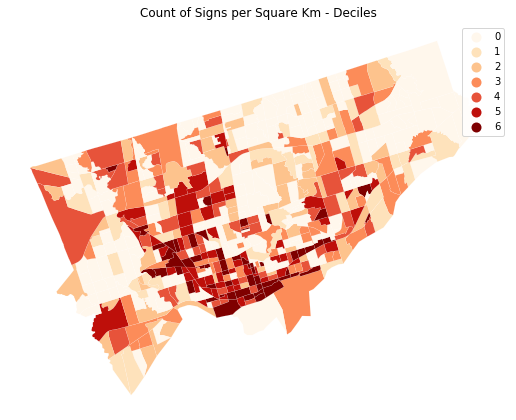

In [86]:
# Visualize the Deciles of sign locations
signs10 = mc.Quantiles(gdf_demproj['Signs_Per_Square_Km'], k=10)

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=signs10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Signs per Square Km - Deciles')
plt.show()

## Spatial Autocorrelation - Signs per Square Km

### Spatial Similarity
As noted in the tutorial, the use of spatial weights "formalize the notion of spatial similarity".  It is used to determine how geographically similar a region is with another.

In [87]:
# Use queen contiguity to apply weights
W = ps.lib.weights.Queen.from_dataframe(gdf_demproj)

# Standardize the rows so all values range from 0 to 1, and the row sum is 1
W.transform = 'r'


In [88]:
print(W)

### Attribute Similarity
Spatial lag is used to measure how similar the attributes are between regions.

In [89]:
signs10Lag = ps.lib.weights.lag_spatial(W, gdf_demproj['Signs_Per_Square_Km'])

In [90]:
signs10LagQ10 = mc.Quantiles(signs10Lag, k=10)

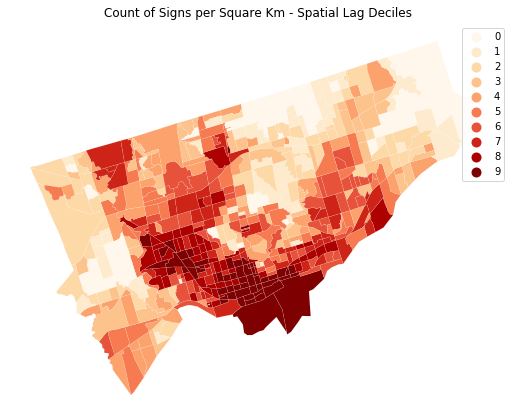

In [91]:
f, ax = plt.subplots(1, figsize=(9,9))

gdf_demproj.assign(cl=signs10LagQ10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Signs per Square Km - Spatial Lag Deciles')
plt.show()

How does the above visualization translate in statistical measures?

In [92]:
signs = gdf_demproj['Signs_Per_Square_Km']
b, a = np.polyfit(signs, signs10Lag, 1)

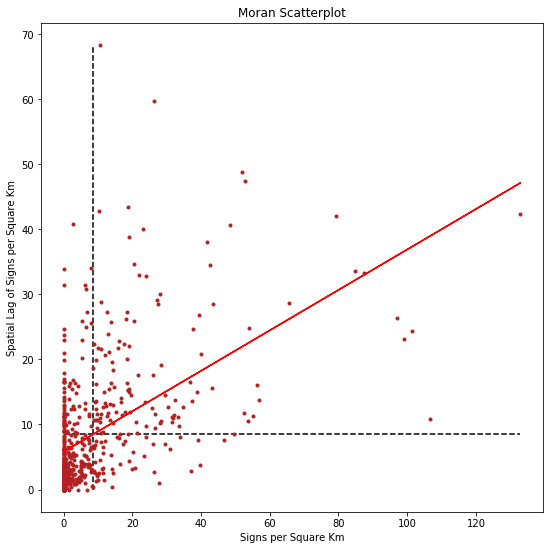

In [93]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(signs, signs10Lag, '.', color='firebrick')

# dashed vert at mean of the average signs per square Km
plt.vlines(signs.mean(), signs10Lag.min(), signs10Lag.max(), linestyle='--')

# dashed horizontal at mean of lagged the average signs per square Km
plt.hlines(signs10Lag.mean(), signs.min(), signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(signs, a+b*signs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Signs per Square Km')
plt.xlabel('Signs per Square Km')
plt.show()

### Global Spatial Autocorrelation
Compute Moran's $I$ statistic to examine the spatial dependence in the Signs per Square Km:

In [94]:
I_signs = ps.explore.esda.Moran(gdf_demproj['Signs_Per_Square_Km'].values, W)

In [95]:
print('The I statistic is ', I_signs.I)
print('The slope of the line is ', b)
print('The p value is ', I_signs.p_sim)

The I statistic is  0.3105542927736304
The slope of the line is  0.3105542927736305
The p value is  0.001


Using the stored collection of simulated $I$ statistics, visualize the results:

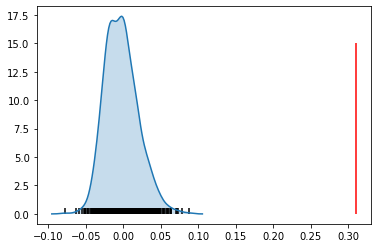

In [96]:
sns.kdeplot(I_signs.sim, shade=True)
plt.vlines(I_signs.sim, 0, 0.5)
plt.vlines(I_signs.I, 0, 15, 'r')

What if the $I$ statistic were close to the expected value of $I$?

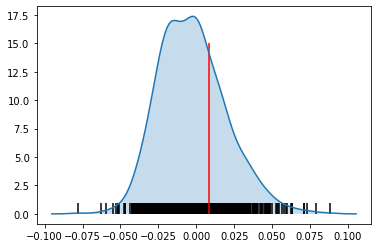

In [97]:
sns.kdeplot(I_signs.sim, shade=True)
plt.vlines(I_signs.sim, 0, 1)
plt.vlines(I_signs.EI+0.01, 0, 15, 'r')


Based on a Moran's $I$ value of 0.31, we can conclude that there is some clustering of similar values (ie. $I$ is a positive value), but the values are somewhat close to being random in nature (ie. $I$ is close to 0).  The $p$-value of 0.001 indicates that this $I$ value was not generated by chance.

Interpretation of $I$ was found on this site:  https://www.statisticshowto.datasciencecentral.com/morans-i/

### Local Autocorrelation Statistics

In [98]:
LMo_signs = ps.explore.esda.Moran_Local(gdf_demproj['Signs_Per_Square_Km'].values, W)

In [99]:
# Check the array of I statistics and p-values
LMo_signs.Is[0:10], LMo_signs.p_sim[0:10]

(array([-1.45067445e-01, -8.66595729e-01,  1.51374208e-04, -2.06040020e-01,
         5.94877486e-02,  2.96323964e-01, -2.16310324e-01,  9.90358339e-03,
         7.53971761e-02,  2.12159828e-01]),
 array([0.013, 0.005, 0.421, 0.326, 0.336, 0.001, 0.156, 0.186, 0.078,
        0.262]))

Adjust the number of permutations to derive every pseudo-$p$ value:

In [100]:
LMo_signs = ps.explore.esda.Moran_Local(gdf_demproj['Signs_Per_Square_Km'].values, W, permutations=9999)

Visualize the Local indicators of spatial association (LISA) statistics.  Highlight the statistically significant LISAs.

In [101]:
# Construct the spatial lag of the covariate
Lag_signs = ps.lib.weights.lag_spatial(W, gdf_demproj['Signs_Per_Square_Km'].values)
signs = gdf_demproj['Signs_Per_Square_Km'].values

In [102]:
# Find the significant and insignificant values
sigs = signs[LMo_signs.p_sim <= 0.001]
W_sigs = Lag_signs[LMo_signs.p_sim <= 0.001]
insigs = signs[LMo_signs.p_sim > 0.001]
W_insigs = Lag_signs[LMo_signs.p_sim > 0.001]

In [103]:
b, a = np.polyfit(signs, Lag_signs, 1)

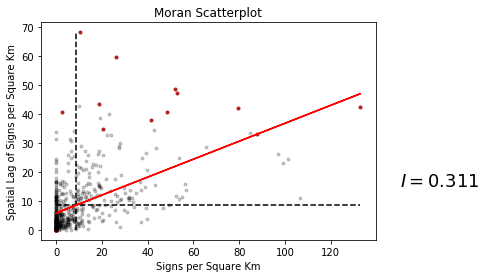

In [104]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)

# dashed vert at mean of the last year's PCI
plt.vlines(signs.mean(), Lag_signs.min(), Lag_signs.max(), linestyle='--')

# dashed horizontal at mean of lagged PCI
plt.hlines(Lag_signs.mean(), signs.min(), signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(signs, a+b*signs, 'r')

plt.text(s='$I = %.3f$' % I_signs.I, x=150, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Signs per Square Km')
plt.xlabel('Signs per Square Km')

plt.show()

Map the LISA data:

In [105]:
sig = LMo_signs.p_sim < 0.05

In [106]:
sig.sum()

154

In [107]:
hotspots = LMo_signs.q==1 * sig

In [108]:
hotspots.sum()

41

In [109]:
coldspots = LMo_signs.q==3 * sig

In [110]:
coldspots.sum()

95

In [111]:
gdf_demproj['Signs_Per_Square_Km'][hotspots]

11      19.041610
12      27.410187
13      96.921064
14      23.184040
15      79.340934
16      10.171686
17      26.233511
18      84.831879
19      10.580492
20     132.896709
21      48.515933
22      52.026905
23      42.648091
24      28.124593
35      20.391673
36      12.919695
39      18.778917
40      24.092077
41      52.742080
42      87.534635
44       8.870618
46      22.035447
47      18.987825
49      18.373261
50      10.834034
67      15.705270
73      65.527835
74      20.505033
77      53.891852
78      41.630082
107     27.303472
109     17.600687
118     98.978543
120     18.176600
122     13.831815
130     16.233272
131     39.402059
132     12.520032
133     43.483006
181     18.584524
183     37.514297
Name: Signs_Per_Square_Km, dtype: float64

In [112]:
gdf_demproj[hotspots].head(10)

spatial_id                    name  Total_Household_Count  \
11  5350010.01  CT0010.01, Toronto, ON                 3438.0   
12  5350010.02  CT0010.02, Toronto, ON                 4846.0   
13  5350011.00  CT0011.00, Toronto, ON                15388.0   
14  5350012.01  CT0012.01, Toronto, ON                 7509.0   
15  5350012.03  CT0012.03, Toronto, ON                 5908.0   
16  5350012.04  CT0012.04, Toronto, ON                 3242.0   
17  5350013.01  CT0013.01, Toronto, ON                 4463.0   
18  5350013.02  CT0013.02, Toronto, ON                 5144.0   
19  5350014.00  CT0014.00, Toronto, ON                 1760.0   
20  5350015.00  CT0015.00, Toronto, ON                 2444.0   

    Total_Population_Count  Total_Income_Over_100K_Count  \
11                  5927.0                        1521.0   
12                  8428.0                        1477.0   
13                 22748.0                        6151.0   
14                 12717.0                        3221.0   
15                  9865.0                        2199.0   
16                  5374.0                        1103.0   
17                  6912.0                        1218.0   
18                  8840.0                        2318.0   
19                  3162.0                         975.0   
20                  4020.0                         982.0   

    Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
11                         232.0                     140155.00   
12                         286.0                     117392.44   
13                        1460.0                     140847.11   
14                         437.0                     118956.71   
15                         313.0                     104835.78   
16                         221.0                     115396.36   
17                         292.0                     121676.93   
18                         674.0                     190069.93   
19                         201.0                     155915.60   
20                         417.0                     216781.71   

    Median_Household_Income_Dollars  \
11                         91780.07   
12                         73670.10   
13                         83229.86   
14                         90228.48   
15                         80070.79   
16                         74458.24   
17                         46576.26   
18                         88129.09   
19                        108501.13   
20                         84073.79   

    Total_Population_Languages_No_Eng_French_Count  \
11                                           119.0   
12                                           301.0   
13                                           246.0   
14                                           501.0   
15                                           201.0   
16                                            91.0   
17                                           133.0   
18                                           142.0   
19                                            39.0   
20                                            25.0   

    Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Household_Count  \
11                               71.2897  ...                          1   
12                               67.8518  ...                          1   
13                               68.8133  ...                          1   
14                               56.2037  ...                          1   
15                               57.3948  ...                          1   
16                               60.1682  ...                          1   
17                               58.8261  ...                          1   
18                               55.9696  ...                          1   
19                               60.3149  ...                          0   
20                               66.9459  ...                          1   

    Above_Avg_Population_Count Above_A

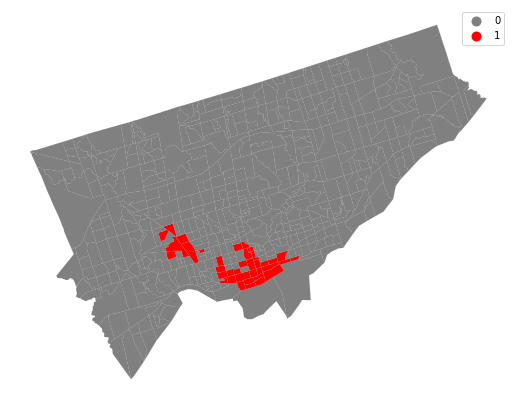

In [113]:
from matplotlib import colors

hmap = colors.ListedColormap(['grey', 'red'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=hmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [114]:
gdf_demproj[coldspots].head(10)

spatial_id                    name  Total_Household_Count  \
5    5350006.00  CT0006.00, Toronto, ON                    0.0   
124  5350102.02  CT0102.02, Toronto, ON                 2695.0   
144  5350119.00  CT0119.00, Toronto, ON                 2460.0   
146  5350121.00  CT0121.00, Toronto, ON                 1555.0   
169  5350139.02  CT0139.02, Toronto, ON                  935.0   
226  5350194.02  CT0194.02, Toronto, ON                 2052.0   
255  5350218.00  CT0218.00, Toronto, ON                 1108.0   
261  5350222.02  CT0222.02, Toronto, ON                 1910.0   
262  5350223.01  CT0223.01, Toronto, ON                  573.0   
264  5350224.00  CT0224.00, Toronto, ON                  579.0   

     Total_Population_Count  Total_Income_Over_100K_Count  \
5                       0.0                           0.0   
124                  4584.0                         465.0   
144                  4914.0                        1204.0   
146                  2853.0                         687.0   
169                  2581.0                         687.0   
226                  6655.0                         315.0   
255                  2871.0                         595.0   
261                  5513.0                         556.0   
262                  1644.0                         364.0   
264                  1713.0                         429.0   

     Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
5                             0.0                          0.00   
124                          89.0                      75372.19   
144                         633.0                     295438.18   
146                         217.0                     182837.67   
169                         387.0                     511331.85   
226                          58.0                      65988.30   
255                         214.0                     219933.58   
261                         143.0                     113352.95   
262                          72.0                     180583.70   
264                         156.0                     320297.87   

     Median_Household_Income_Dollars  \
5                               0.00   
124                         44498.00   
144                         96255.40   
146                         89833.36   
169                        216118.31   
226                         39852.84   
255                        107370.96   
261                         51324.27   
262                        129530.16   
264                        189255.60   

     Total_Population_Languages_No_Eng_French_Count  \
5                                               0.0   
124                                           122.0   
144                                            39.0   
146                                             4.0   
169                                             2.0   
226                                           423.0   
255                                            14.0   
261                                           101.0   
262                                            21.0   
264                                            23.0   

     Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Household_Count  \
5                                  0.0000  ...                          0   
124                               50.9739  ...                          1   
144                               75.3728  ...                          1   
146                               80.6009  ...                          0   
169                               85.1608  ...                          0   
226                               27.3269  ...                          0   
255                               76.7109  ...                          0   
261                               49.3534  ...                          0   
262                               63.0170  ...                          0   
264                               67.3672  ...     

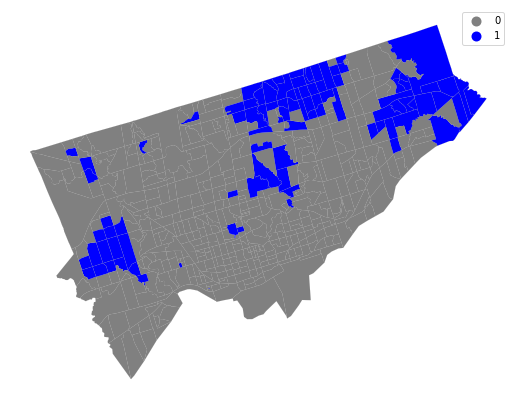

In [115]:
cmap = colors.ListedColormap(['grey', 'blue'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=cmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

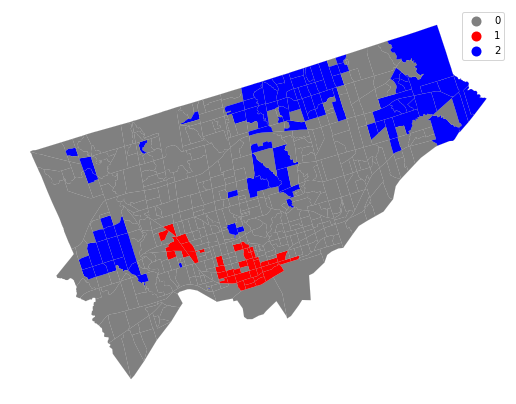

In [116]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=hotcold).plot(column='cl', categorical=True, \
                                      k=2, cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

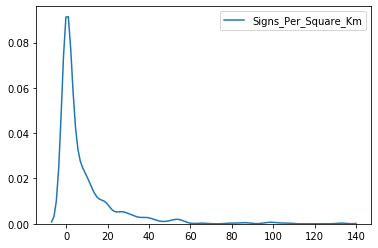

In [117]:
sns.kdeplot(gdf_demproj['Signs_Per_Square_Km'])

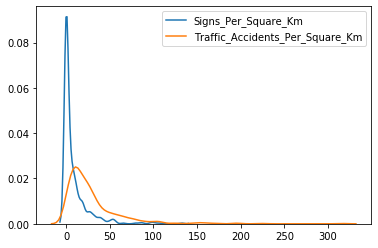

In [118]:
sns.kdeplot(gdf_demproj['Signs_Per_Square_Km'])
sns.kdeplot(gdf_demproj['Traffic_Accidents_Per_Square_Km'])

In [119]:
gdf_demproj['Signs_Per_Square_Km'].mean()

8.646983952428505

In [120]:
gdf_demproj['Signs_Per_Square_Km'].median()

1.957350295442704

In [121]:
print(LMo_signs.q)

[2 2 3 4 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 3 3 2 2 1 2 1 2 1 1
 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 3 2 3 2 4 2 4 4 1 1 1 2 1 1 2 2 1 2 1
 1 2 1 1 1 3 3 4 2 3 3 2 4 4 1 1 1 2 1 1 2 1 1 1 1 2 2 2 2 3 3 3 2 1 1 1 1
 2 1 1 2 1 2 2 1 2 1 1 1 1 3 2 3 2 2 2 1 1 1 1 2 1 2 1 1 1 2 4 2 3 3 2 3 3
 3 3 3 1 4 4 2 1 4 1 3 3 2 3 3 3 3 2 3 3 3 3 3 4 4 3 2 1 1 2 2 1 2 1 1 1 1
 1 1 1 1 1 2 2 4 3 2 4 2 2 1 2 2 1 1 1 1 1 2 2 3 3 3 3 3 3 4 3 3 3 3 2 3 1
 1 1 3 3 3 3 3 3 4 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2 3 4 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3
 3 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 1 1 1 2 4 4 2 3 4 2 3 3 2 1 1 2 1 1 1 3 4 3 4 2 3 3 3 3 3
 3 3 4 3 2 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2 3 2 3 3 2 1 4 3 3 4
 3 3 3 3 3 3 4 3 3 3 1 1 1 3 3 1 2 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 4 1 3 2 2 1 3 3 4 4 4 2 3 2 4 3 1 3 1 3 2 4 4 3 2
 3 3 4 2 3 3 3 3 3 3 4 3 

## Spatial Autocorrelation - Traffic Accidents per Signs per Square Km

### Spatial Similarity
As noted in the tutorial, the use of spatial weights "formalize the notion of spatial similarity".  It is used to determine how geographically similar a region is with another.

In [122]:
# Determine the number of traffic accidents per sign per square km
# If there are no signs, use zero
gdf_demproj['Acc_Per_Sign_Per_Km'] = 0
gdf_demproj.loc[gdf_demproj['Signs_Per_Square_Km'] > 0, 'Acc_Per_Sign_Per_Km'] = \
                gdf_demproj['Traffic_Accidents_Per_Square_Km'] / gdf_demproj['Signs_Per_Square_Km']
gdf_demproj.head()

spatial_id                    name  Total_Household_Count  \
0  5350001.00  CT0001.00, Toronto, ON                  249.0   
1  5350002.00  CT0002.00, Toronto, ON                  267.0   
2  5350003.00  CT0003.00, Toronto, ON                  537.0   
3  5350004.00  CT0004.00, Toronto, ON                 3712.0   
4  5350005.00  CT0005.00, Toronto, ON                 3722.0   

   Total_Population_Count  Total_Income_Over_100K_Count  \
0                   600.0                          88.0   
1                   613.0                          74.0   
2                  1557.0                         219.0   
3                  7177.0                         342.0   
4                  6969.0                         445.0   

   Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
0                          15.0                     120561.50   
1                           7.0                      75392.63   
2                          28.0                     120833.84   
3                         121.0                      54432.35   
4                         127.0                      65003.69   

   Median_Household_Income_Dollars  \
0                         79727.91   
1                         74505.79   
2                         88073.28   
3                         27670.45   
4                         33807.26   

   Total_Population_Languages_No_Eng_French_Count  \
0                                            22.0   
1                                             0.0   
2                                            17.0   
3                                           392.0   
4                                           301.0   

   Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Population_Count  \
0                               72.5000  ...                           0   
1                               89.1566  ...                           0   
2                               53.8462  ...                           0   
3                               50.0513  ...                           1   
4                               55.8916  ...                           1   

   Above_Avg_Over_100K_Count Above_Avg_Over_250K_Count  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   Above_Avg_AvgHousehold_Income_Dollars  \
0                                      1   
1                                      0   
2                                      1   
3                                      0   
4                                      0   

   Above_Avg_MedHousehold_Income_Dollars  Above_Avg_Pop_No_Eng_Fr_Count  \
0                                      1                              0   
1                                      1                              0   
2                                      1                              0   
3                                      0                              1   
4                                      0                              1   

   Above_Avg_Pop_Eng_First_Count  Above_Avg_Consumption_Dollars  \
0                              1                              0   
1                              1                              0   
2                              1                              0   
3                              0                              0   
4                              1                              1   

   Above_Avg_Expenditure_Dollars  Acc_Per_Sign_Per_Km  
0                              0             0.755556  
1                              0             0.000000  
2                              0            19.285714  
3                              0             2.750000  
4                              0             1.600000  

[5 rows x 29 columns]

In [123]:
# Use queen contiguity to apply weights
W = ps.lib.weights.Queen.from_dataframe(gdf_demproj)

# Standardize the rows so all values range from 0 to 1, and the row sum is 1
W.transform = 'r'


### Attribute Similarity
Spatial lag is used to measure how similar the attributes are between regions.

In [124]:
acc_signs10Lag = ps.lib.weights.lag_spatial(W, gdf_demproj['Acc_Per_Sign_Per_Km'])

In [125]:
acc_signs10LagQ10 = mc.Quantiles(acc_signs10Lag, k=10)

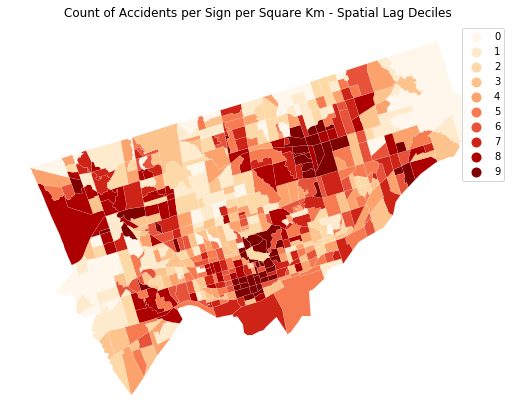

In [126]:
f, ax = plt.subplots(1, figsize=(9,9))

gdf_demproj.assign(cl=acc_signs10LagQ10.yb).plot(column='cl', categorical=True, \
                                      k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Count of Accidents per Sign per Square Km - Spatial Lag Deciles')
plt.show()

How does the above visualization translate in statistical measures?

In [127]:
acc_signs = gdf_demproj['Acc_Per_Sign_Per_Km']
b, a = np.polyfit(acc_signs, acc_signs10Lag, 1)

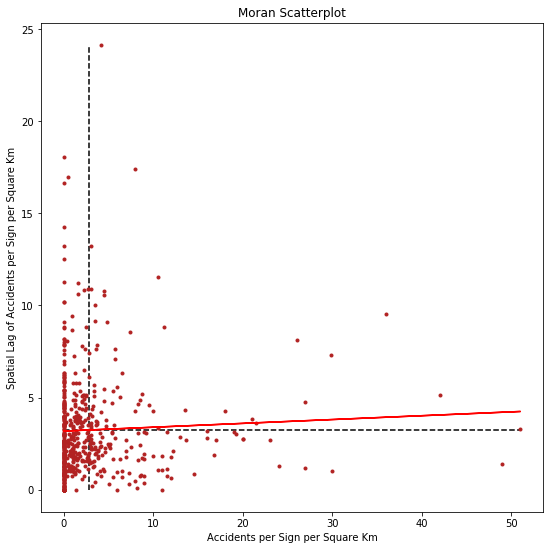

In [128]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(acc_signs, acc_signs10Lag, '.', color='firebrick')

# dashed vert at mean of the last year's PCI
plt.vlines(acc_signs.mean(), acc_signs10Lag.min(), acc_signs10Lag.max(), linestyle='--')

# dashed horizontal at mean of lagged PCI
plt.hlines(acc_signs10Lag.mean(), acc_signs.min(), acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(acc_signs, a+b*acc_signs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')
plt.show()

### Global Spatial Autocorrelation
Compute Moran's $I$ statistic to examine the spatial dependence in the Accidents per Sign per Square Km:

In [129]:
I_acc_signs = ps.explore.esda.Moran(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W)

In [130]:
print('The I statistic is ', I_acc_signs.I)
print('The slope of the line is ', b)
print('The p value is ', I_acc_signs.p_sim)

The I statistic is  0.020861565833143532
The slope of the line is  0.020861565833143598
The p value is  0.166


Using the stored collection of simulated $I$ statistics, visualize the results:

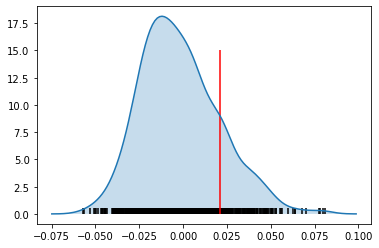

In [131]:
sns.kdeplot(I_acc_signs.sim, shade=True)
plt.vlines(I_acc_signs.sim, 0, 0.5)
plt.vlines(I_acc_signs.I, 0, 15, 'r')

What if the $I$ statistic were close to the expected value of $I$?

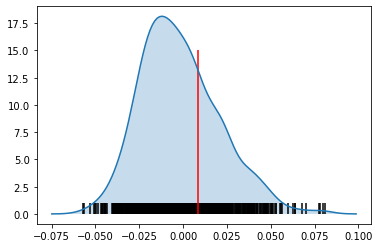

In [132]:
sns.kdeplot(I_acc_signs.sim, shade=True)
plt.vlines(I_acc_signs.sim, 0, 1)
plt.vlines(I_acc_signs.EI+0.01, 0, 15, 'r')


Based on a Moran's $I$ value of 0.02, we can conclude that there is no autocorrelation, indicating close to perfect randomness (ie. $I$ is almost a zero value).  The $p$-value of 0.181 indicates that this $I$ value could have been generated by chance.  We cannot reject the null hypothesis here.

Interpretation of $I$ was found on this site:  https://www.statisticshowto.datasciencecentral.com/morans-i/

### Local Autocorrelation Statistics

In [133]:
LMo_acc_signs = ps.explore.esda.Moran_Local(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W)

In [134]:
# Check the array of I statistics and p-values
LMo_acc_signs.Is[0:10], LMo_acc_signs.p_sim[0:10]

(array([ 0.008546  , -0.07552645,  0.07358024, -0.00222352,  0.04388362,
         0.24996317, -0.14640229, -0.01729986,  0.0164991 , -0.05404939]),
 array([0.371, 0.259, 0.358, 0.287, 0.33 , 0.001, 0.185, 0.218, 0.377,
        0.256]))

Adjust the number of permutations to derive every pseudo-$p$ value:

In [135]:
LMo_acc_signs = ps.explore.esda.Moran_Local(gdf_demproj['Acc_Per_Sign_Per_Km'].values, W, permutations=9999)

Visualize the Local indicators of spatial association (LISA) statistics.  Highlight the statistically significant LISAs.

In [136]:
# Construct the spatial lag of the covariate
Lag_acc_signs = ps.lib.weights.lag_spatial(W, gdf_demproj['Acc_Per_Sign_Per_Km'].values)
acc_signs = gdf_demproj['Acc_Per_Sign_Per_Km'].values

In [137]:
# Find the significant and insignificant values
acc_sigs = acc_signs[LMo_acc_signs.p_sim <= 0.001]
acc_W_sigs = Lag_acc_signs[LMo_acc_signs.p_sim <= 0.001]
acc_insigs = acc_signs[LMo_acc_signs.p_sim > 0.001]
acc_W_insigs = Lag_acc_signs[LMo_acc_signs.p_sim > 0.001]

In [138]:
b, a = np.polyfit(acc_signs, Lag_acc_signs, 1)

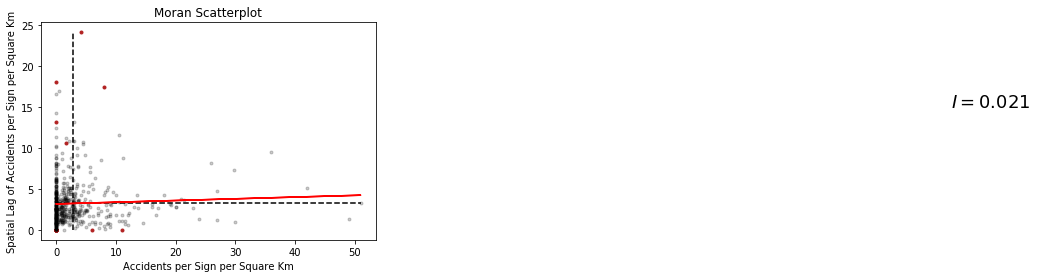

In [139]:
plt.plot(acc_sigs, acc_W_sigs, '.', color='firebrick')
plt.plot(acc_insigs, acc_W_insigs, '.k', alpha=.2)

# dashed vert at mean of the last year's PCI
plt.vlines(acc_signs.mean(), Lag_acc_signs.min(), Lag_acc_signs.max(), linestyle='--')

# dashed horizontal at mean of lagged PCI
plt.hlines(Lag_acc_signs.mean(), acc_signs.min(), acc_signs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(acc_signs, a+b*acc_signs, 'r')

plt.text(s='$I = %.3f$' % I_acc_signs.I, x=150, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Accidents per Sign per Square Km')
plt.xlabel('Accidents per Sign per Square Km')

plt.show()

Map the LISA data:

In [140]:
acc_sig = LMo_acc_signs.p_sim < 0.05

In [141]:
acc_sig.sum()

79

In [142]:
acc_hotspots = LMo_acc_signs.q==1 * acc_sig

In [143]:
acc_hotspots.sum()

17

In [144]:
acc_coldspots = LMo_acc_signs.q==3 * acc_sig

In [145]:
acc_coldspots.sum()

30

In [146]:
gdf_demproj['Acc_Per_Sign_Per_Km'][acc_hotspots]

17      5.666667
19     29.800000
38     10.500000
40      3.000000
41      3.714286
43     36.000000
44     11.250000
45      7.428571
46      4.857143
76      4.500000
79      8.000000
329     3.500000
331     4.500000
334     3.000000
379     3.444444
518     4.142857
520    26.000000
Name: Acc_Per_Sign_Per_Km, dtype: float64

In [147]:
gdf_demproj[acc_hotspots].head(10)

spatial_id                    name  Total_Household_Count  \
17  5350013.01  CT0013.01, Toronto, ON                 4463.0   
19  5350014.00  CT0014.00, Toronto, ON                 1760.0   
38  5350032.00  CT0032.00, Toronto, ON                 2826.0   
40  5350034.01  CT0034.01, Toronto, ON                 2456.0   
41  5350034.02  CT0034.02, Toronto, ON                 3410.0   
43  5350036.00  CT0036.00, Toronto, ON                 3601.0   
44  5350037.00  CT0037.00, Toronto, ON                 2282.0   
45  5350038.00  CT0038.00, Toronto, ON                 1784.0   
46  5350039.00  CT0039.00, Toronto, ON                 1865.0   
76  5350063.04  CT0063.04, Toronto, ON                 2449.0   

    Total_Population_Count  Total_Income_Over_100K_Count  \
17                  6912.0                        1218.0   
19                  3162.0                         975.0   
38                  5776.0                         351.0   
40                  5027.0                         450.0   
41                  5765.0                         735.0   
43                  6016.0                         766.0   
44                  4798.0                         365.0   
45                  4035.0                         362.0   
46                  4608.0                         211.0   
76                  3655.0                         408.0   

    Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
17                         292.0                     121676.93   
19                         201.0                     155915.60   
38                         117.0                      66577.45   
40                          92.0                      68950.47   
41                         125.0                      73626.00   
43                         200.0                      91907.70   
44                         115.0                      73054.10   
45                          77.0                      76207.53   
46                          59.0                      57028.00   
76                         117.0                      86150.62   

    Median_Household_Income_Dollars  \
17                         46576.26   
19                        108501.13   
38                         25500.85   
40                         34480.61   
41                         40976.86   
43                         48919.82   
44                         33871.31   
45                         35545.01   
46                         27447.35   
76                         39377.47   

    Total_Population_Languages_No_Eng_French_Count  \
17                                           133.0   
19                                            39.0   
38                                           150.0   
40                                           194.0   
41                                            82.0   
43                                           756.0   
44                                           422.0   
45                                           849.0   
46                                          1045.0   
76                                            46.0   

    Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Population_Count  \
17                               58.8261  ...                           1   
19                               60.3149  ...                           0   
38                               65.1638  ...                           1   
40                               50.6743  ...                           0   
41                               63.8733  ...                           1   
43                               50.7926  ...                           1   
44                               45.2593  ...                           0   
45                               43.6401  ...                           0   
46                               37.7881  ...                           0   
76                               65.8088  ...                           0   

    Above_Avg_Over_100K_Cou

In [148]:
from matplotlib import colors

hmap = colors.ListedColormap(['grey', 'red'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_hotspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=hmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [149]:
gdf_demproj[acc_coldspots].head(10)

spatial_id                    name  Total_Household_Count  \
5    5350006.00  CT0006.00, Toronto, ON                    0.0   
173  5350142.00  CT0142.00, Toronto, ON                 2368.0   
261  5350222.02  CT0222.02, Toronto, ON                 1910.0   
262  5350223.01  CT0223.01, Toronto, ON                  573.0   
272  5350230.02  CT0230.02, Toronto, ON                 2792.0   
274  5350232.00  CT0232.00, Toronto, ON                 1390.0   
275  5350233.00  CT0233.00, Toronto, ON                 2106.0   
276  5350234.00  CT0234.00, Toronto, ON                 1700.0   
288  5350240.02  CT0240.02, Toronto, ON                 2735.0   
342  5350277.00  CT0277.00, Toronto, ON                 1318.0   

     Total_Population_Count  Total_Income_Over_100K_Count  \
5                       0.0                           0.0   
173                  6149.0                        1296.0   
261                  5513.0                         556.0   
262                  1644.0                         364.0   
272                  7007.0                         758.0   
274                  4066.0                         996.0   
275                  5869.0                        1092.0   
276                  4798.0                         820.0   
288                  6452.0                         565.0   
342                  4416.0                         825.0   

     Total_Income_Over_250K_Count  Avg_Household_Income_Dollars  \
5                             0.0                          0.00   
173                         426.0                     218687.39   
261                         143.0                     113352.95   
262                          72.0                     180583.70   
272                         214.0                     125179.62   
274                         528.0                     377699.16   
275                         244.0                     159694.09   
276                         117.0                     133008.71   
288                         112.0                      82171.70   
342                         416.0                     335123.47   

     Median_Household_Income_Dollars  \
5                               0.00   
173                        111072.55   
261                         51324.27   
262                        129530.16   
272                         58888.44   
274                        209223.13   
275                        104071.17   
276                         97029.05   
288                         46115.02   
342                        144359.63   

     Total_Population_Languages_No_Eng_French_Count  \
5                                               0.0   
173                                            58.0   
261                                           101.0   
262                                            21.0   
272                                           241.0   
274                                            27.0   
275                                           131.0   
276                                           101.0   
288                                           250.0   
342                                            16.0   

     Total_Houshold_Mother_Tongue_Eng_Pct  ...  Above_Avg_Population_Count  \
5                                  0.0000  ...                           0   
173                               79.4855  ...                           1   
261                               49.3534  ...                           1   
262                               63.0170  ...                           0   
272                               40.6830  ...                           1   
274                               71.4953  ...                           0   
275                               57.0114  ...                           1   
276                               57.7115  ...                           0   
288                               38.5991  ...                           1   
342                               73.7092

In [150]:
cmap = colors.ListedColormap(['grey', 'blue'])

f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_coldspots*1).plot(column='cl', categorical=True, \
                                      k=2, cmap=cmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

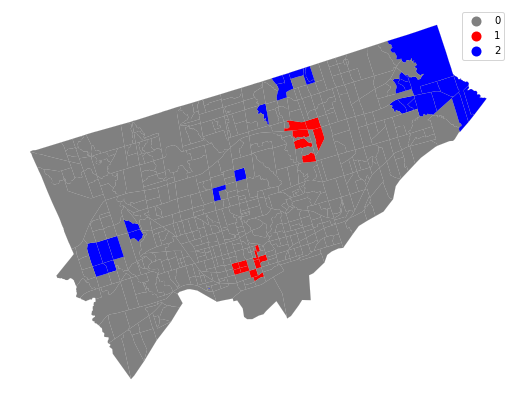

In [151]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
acc_hotcold = acc_hotspots*1 + acc_coldspots*2
f, ax = plt.subplots(1, figsize=(9,9))
gdf_demproj.assign(cl=acc_hotcold).plot(column='cl', categorical=True, \
                                      k=2, cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

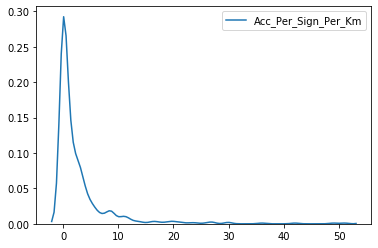

In [152]:
sns.kdeplot(gdf_demproj['Acc_Per_Sign_Per_Km'])

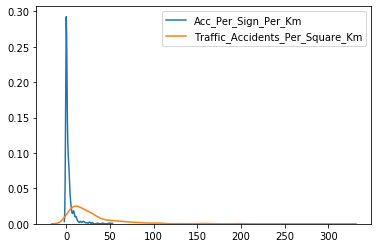

In [153]:
sns.kdeplot(gdf_demproj['Acc_Per_Sign_Per_Km'])
sns.kdeplot(gdf_demproj['Traffic_Accidents_Per_Square_Km'])

In [154]:
gdf_demproj['Acc_Per_Sign_Per_Km'].mean()

2.8699004396706

In [155]:
gdf_demproj['Acc_Per_Sign_Per_Km'].median()

0.9372549019607843